# Data and libraries

In [104]:
import math
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp
from scipy.optimize import fsolve
import scipy.integrate as integrate
import warnings

warnings.filterwarnings('ignore', category=DeprecationWarning)

In [105]:
#Data

#Reactor
Pr=1500 #MW                             #Reactor power
iAs=180                                 #number of inner core assemblies
oAs=108                                 #number of outer core assembliess
p=10.7  #mm                             # pin pitch 
Npins=217                               #pins per assembly
Tcin=400 #°C                            #Inlet coolant temperature                        
Pincoolant=0.3 #Mpa                     #Inlet coolant temperature
mfr_ass=22 # (kg s-1)                   #Mass flow rate per assembly 
TargetB= 135 #GWd/t                     #Target Fuel burnup
fluxt=3.38*10**15 #cm^-1s^-1            #Total neutron flux
fluxf=0.7*fluxt #cm^-1s^-1              #Fast neutron flux


#Fuel pin
aL=1100 #mm                             #pin active length
lfeH=300 #mm                            #Lower fertile zone height
lfiH=250 #mm                            #Lower fissile zone height
ifeH=200 #mm                            #Inner fertile zone height
ufiH=350 #mm                            #Upper fissile zone height
fiRfi= 2.45/2 #mm                       #Fuel inner diameter (mm) – fissile pellets
feRfi=0                                 #Fuel inner diameter (mm) – fertile pellets
Rfo= 8.46/2 #mm                         #Fuel outer diameter
Rco=9.7/2 # (mm)                        #cladding outer radius
Wd=1 #mm                                #Wire spacer diameter
Pingas=0.1 #Mpa                           #Initial pin inner pressure
Tgas=20 #°C                             #Initial pin inner temperature
rhof=0.95 #%TD                          #Fuel density (percentage of theoretical density)
grainD= 10#micron                       #fuel grain diameter
Ppeak=46.3 # W/mm                       #axial peak power
x_fissile=0.03 #\                       #O-to-m ratio
alpha=1.2*10**-5 #°C**-1                #fuel expansion coefficient
#Axial peak factors
Pf=[0.001,0.005,0.01,0.03,0.205,0.38,0.45,0.51,0.55,0.57,0.58,0.315,0.05,0.04,0.04,0.05,0.06,0.08,0.46,0.84,0.89,0.94,0.98,1,0.98,0.92,0.86,0.81,0.77,0.71]
#Corrisponding height nodes
H=[0,130,230,290,300,310,350,400,450,490,540,550,560,590,630,670,700,740,750,760,770,790,830,880,930,980,1020,1050,1070,1100]

Nav=6.022*10**23                        # Avogadro number

In [106]:
#Molar Masses

MM_UO_2=238+16+16 #g/mol
MM_MOX= 16*(2-x_fissile)+(0.23*239+0.67*238)*(1+x_fissile)

*Throttling-adjusted flow rate*

Throttling is the adjustement of the flow rate of a single assembly by opening and closing a valve at its inlet. By doing so, the heat exchenge can be enhanced or reduced.

For the scope of this work, it is sufficient to model this feature as a coefficient multiplying the standard mass flow rate.

In [107]:
throttling=1.9                         #throttling parameter
mfr=throttling*mfr_ass/(217)            #mass flow rate per pin adjusted by throttling

Pin-coolant Heat exchange geometrical parametrs

In [108]:
A=(p**2/4*math.sqrt(3)-math.pi*Rco**2/2)*10**-6 #m**2       #coolant channel section seen by a pin
Dh=4*A*1000/(math.pi*Rco) #m                                #Characteristic length of the pin (wet diameter)

# Interpolation

In this section, an interpolation of the axial peak factor is developed in order to calculate the temperature of the coolant along the pin active length.

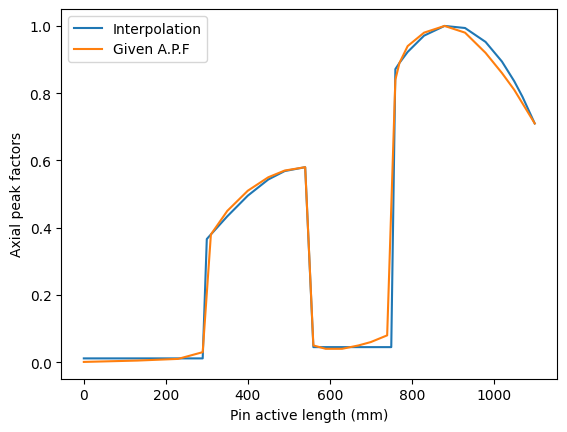

In [109]:
#values and parameters for the interpolations

#for f_1
val_f1=0                                       
for i in range(4):                             
    val_f1=val_f1+Pf[i]
########################

#for f_4 and f_3
val_f4=0                                      
for i in range(5):                            
    val_f4=val_f4+Pf[i+13]
###########################


#for f_3
m,q=sp.symbols('m q')                         
def f(x):                                      
    return m*x+q

x1=f(H[10])
x2=f(H[12])

sol_3=sp.solve( (sp.Eq(x1,Pf[10]), sp.Eq(x2,val_f4/6)), [m,q] )
###############################################################


#for f_5
C1,C2,C=sp.symbols('C1 C2 C')            
def f(x):
    return C+C1*x+C2*x**2
x1=f(H[20])
x2=f(H[23])
x3=f(H[29])
sol_5=sp.solve( (sp.Eq(x1,Pf[20]), sp.Eq(x2, Pf[23]), sp.Eq(x3,Pf[29])), [C1, C2, C])
####################################################################################

############################################################################################################################
###############   ACTUAL FUNCTIONS   ########################################################################################
#############################################################################################################################

def f1(x):                         #constant function interpolation of the axial peak factors (first fertile zone)
    return val_f1/4                #[0,300) 


#############################################################################################################################
def f2(x):                                     #sine function interpolation of the axial peak factors (first fissile zone)
                                               #[300,540)  
    return Pf[5]+(Pf[10]-Pf[5])*math.sin((x-H[5])*math.pi*0.5/(H[10]-H[5]))


#############################################################################################################################
def f3(x):                                   #linear interpolation of the axial peak factors (steep interface)
    return sol_3[m]*x +sol_3[q]                  #[540, 560)


#############################################################################################################################
def f4(x):                                    #constant function interpolation of the axial peak factors (second fertile zone)
    return val_f4/6                           #[560,700)


#############################################################################################################################


def f5(x):                                   #parabolic function interpolation of the axial peak factors (first fissile zone)
    return sol_5[C]+sol_5[C1]*x+sol_5[C2]*x**2     #[700,1100]


def PeakFactor(x):   #x is the disance from the bottom of the pin in mm, the function returns the value of the peak factor interpolated.
    if x<=H[3]:
        return(f1(x))
    elif x<=H[10]:
        return(f2(x))
    elif x<=H[12]:
        return f3(x)
    elif x<=H[18]:
        return(f4(x))
    else:
        return(f5(x))

Pfvals=[]
xvals=np.linspace(H[0],H[29],1101) #array of 1101, one for each active length mm
for i in range(len(H)):
    Pfvals.append(PeakFactor(H[i]))

plt.plot(H,Pfvals, label="Interpolation")
plt.plot(H,Pf, label="Given A.P.F")
plt.xlabel("Pin active length (mm)")
plt.ylabel("Axial peak factors")
plt.legend()

# Cold geometry

With cold geometry, we refer to the temperature profile, axial and radial, of the pin and the coolant without taking into account the deferormations due to temperature. The "cold" geometry is hence the geometry of the pin at 20°C.

Symbols used in the following:
* $\Gamma$:  Mass flow rate
* $C_p$:  coolant specific heat
* z: axial coordinate null at the basis of the pin active length
* $ q'(z)= A.P.F.(z) \cdot q'_{max} $ : linear power

**Coolant Temperature Profile**


The temperature profile of the coolant along the axial cordinates will evolve following the equation:
\begin{equation}
    \Gamma C_p\frac{dT}{dz}(z)=q'(z) \tag{1}
\end{equation}

This equation was integrated to find the coolant profile, knowing the inlet coolant temperature.





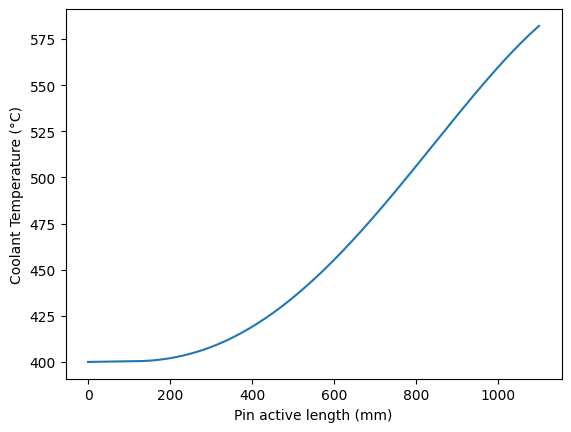

In [110]:
##Temperature conversion °C --> °F

#Celsius to Fahrenheit
def C2F(T):
  
  return (T*(9/5) + 32)

########################################################################
########################## COOLANT PROPERTIES ##########################
########################################################################

#Coolant heat capacity J/(K kg)
def Cp(T):
    return 971.34 - 3.69*10**(-1)*T + (3.43*10**(-4))*T**2


#Density (Kg m^-3)
def Rho(T):
  Tf=C2F(T)
  return 954.1579 + Tf * (Tf * (Tf * 0.9667*10**(-9) - 0.46*10**(-5)) - 0.1273534)

#coolant speed (m/s)
def v_c(T):
  return mfr/(Rho(T)*A*2)

#Thermal conductivity (W m^-1 K^-1)
def K_c(T):
  Tf=C2F(T)
  return 94 - 3.25*10**(-2)*Tf + 3.62*10**(-6)*Tf**2

#Peclet number
def Pe(T):
  return Rho(T)*v_c(T)*Dh*Cp(T)/K_c(T)

#Nusselt number
def Nu(T):
  return 7 + 0.025*(Pe(T))**(0.8)

#Heat transfer coefficient (W m^-2 K^-1)
def h(T):
  return Nu(T)*K_c(T)/(Dh)

########################################################################
########################## Coolant T profile ###########################
########################################################################

#Linear Power #W/mm
def Plin(z):

    return Ppeak*PeakFactor(z)  #the linear power @z is the max power Ppeak * the corresponding axial peak factor

# T coolant
def dTdz(z, T):  

    return (Plin(z)/(mfr*Cp(T)))

#solution of previous equation to find coolant temperature profile along z
sol=integrate.solve_ivp(dTdz, (H[0],H[29]), [400], t_eval=xvals[H[0]:H[29]+1]) 

plt.plot(sol.t, sol.y[0])
plt.xlabel("Pin active length (mm)")
plt.ylabel("Coolant Temperature (°C)")

T=np.zeros(len(H)) #coolant temperature @nodes
Cp_v=np.zeros(len(H)) #coolant specific activity @nodes

for i in range(len(H)):           #here, only the values of temperature and specific activity in proximity of the nodes are selected
    T[i]=sol.y[0][int(H[i])]
    Cp_v[i]=Cp(T[i])

By means of the provided correlations, the properties and characteristic parameters of interest for the coolant are calculated and plotted.

From now on, there is no more need for 1101 points in the calculations, but the analysis will be done in proximity of the nodes provided along with the axial peak factors.

The values of the needed parametrs like thermal conductivity, specific heat etc. will be calculated with the values relative to that points only.

These values will be used first to find the outer temperature of the cladding, and then inward with the inner cladding temperature until reaching the inner fuel temperature.

In [111]:
Rho_v=np.zeros(len(H)) #coolant density
v_c_v=np.zeros(len(H)) #coolant speed
k_c_v=np.zeros(len(H)) #cladding thermal conductivity
h_v=np.zeros(len(H))   #heat transfer coefficient
for i in range(len(H)): #here, only the values of coolant properties in proximity of the nodes are selected
    Rho_v[i]=Rho(T[i])
    v_c_v[i]=v_c(T[i])
    k_c_v[i]=K_c(T[i])
    h_v[i]=h(T[i])

There is a constraint on the speed of the coolant (<10 m/s) due to the fact that high-speed molten lead may corrode the cladding iron but if throttling rises, so does the speed while the cladding maximum temperatures lowers and vicde versa.


Hence, the need for choosing the throttling factor as a covenient trade-off between corrosion and pin temperature arises.

A 1.9 throttling seemes the value that suits the best.

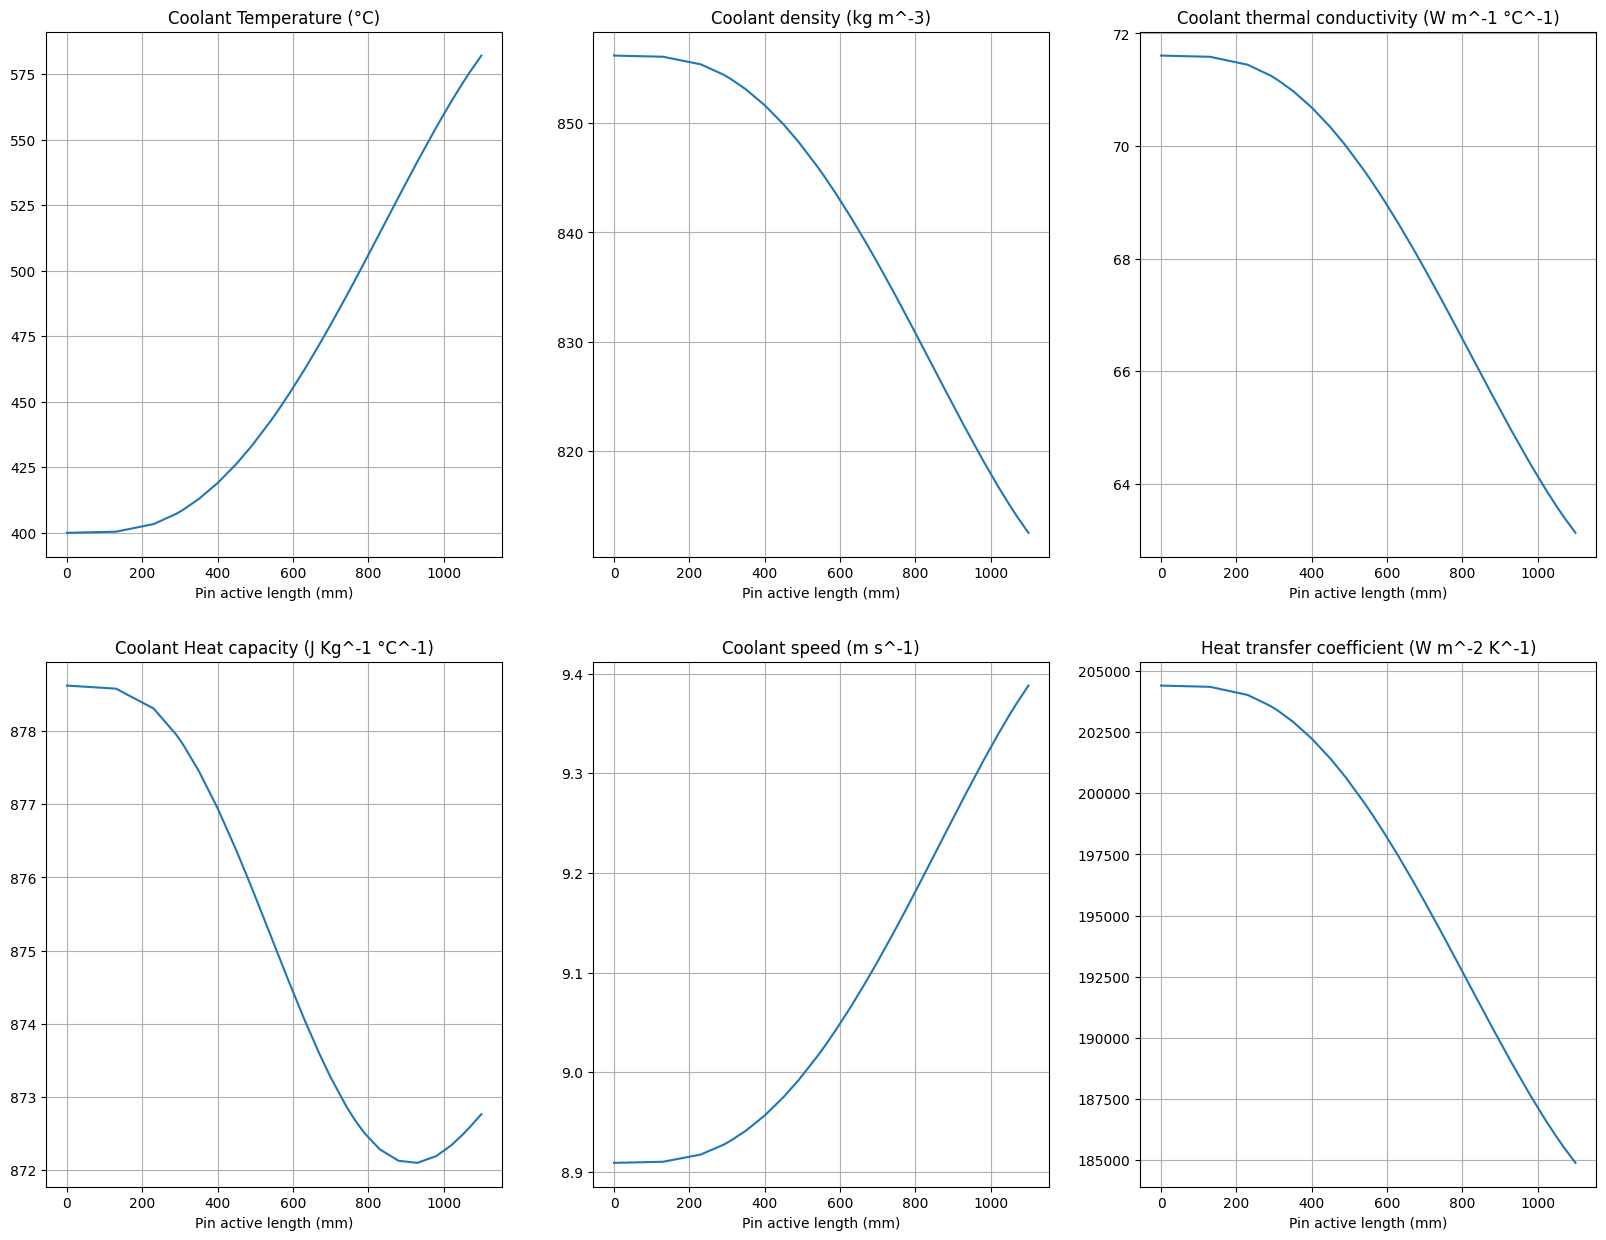

In [112]:
#plots                                                      #all coolant properties plotted
fig, axs = plt.subplots(2, 3, figsize=(20,15))

axs[0, 0].plot(H, T)
axs[0, 0].set_title('Coolant Temperature (°C)')
axs[0, 0].set_xlabel("Pin active length (mm)")
axs[0, 0].grid()
axs[1, 0].plot(H, Cp_v)
axs[1, 0].set_title('Coolant Heat capacity (J Kg^-1 °C^-1)')
axs[1, 0].set_xlabel("Pin active length (mm)")
axs[1, 0].grid()

axs[0, 1].plot(H, Rho_v)
axs[0, 1].set_title('Coolant density (kg m^-3)')
axs[0, 1].set_xlabel("Pin active length (mm)")
axs[0, 1].grid()
axs[1, 1].plot(H, v_c_v)
axs[1, 1].set_title('Coolant speed (m s^-1)')
axs[1, 1].set_xlabel("Pin active length (mm)")
axs[1, 1].grid()

axs[0, 2].plot(H, k_c_v)
axs[0, 2].set_title('Coolant thermal conductivity (W m^-1 °C^-1)')
axs[0, 2].set_xlabel("Pin active length (mm)")
axs[0, 2].grid()
axs[1, 2].plot(H, h_v)
axs[1, 2].set_title('Heat transfer coefficient (W m^-2 K^-1)')
axs[1, 2].set_xlabel("Pin active length (mm)")
axs[1, 2].grid()

**Cladding outern temperature profile**

The following assumptions are made in the calculations of $T_{c,o}(z)$:

$T_{c,o}(0)=400°C$: this is due to the heat transfer being assumed to be only radial and subsequently at $z=0$ there hasn't been any heat transfer yet. If at $z=0$ there is no heat transfer, then the cladding and coolant have same temperature.\
So:
\begin{equation}
T_{c,o,i}=T_{i}+\frac{q'_{max}P_{f,i}}{h(T_{i})2R_{c,o}π} \tag{2}
\end{equation}

Text(0.5, 0, 'Pin active length (mm)')

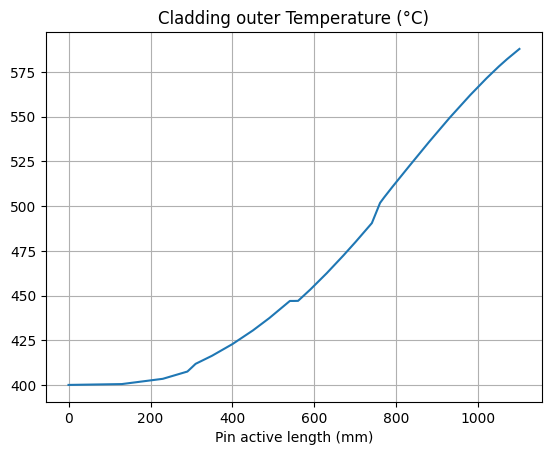

In [113]:
#Cladding outer temperature
Tco=np.zeros(len(H))

for i in range(len(H)):
  Tco[i]=T[i]+(Ppeak*Pf[i]*1000/(h_v[i]*2*math.pi*(Rco/1000))) #temperature calculated for each node

plt.plot(H,Tco)                               #temperature plotted vs pin active length
plt.grid()
plt.title('Cladding outer Temperature (°C)')
plt.xlabel("Pin active length (mm)")

**Cladding thickness problem**

The most basic geometrical limit for the cladding thickness is given by the fixed outern radius for both cladding and fuel.

In [114]:
#Cladding possible thickness
k=0
count=100
tc=np.zeros(count)

while k<count: #array of possible thickness values for the cladding
    tc[k]=(Rco-Rfo)*k/count
    k=k+1


**Cladding inner temperature**\
For the calculation of the cladding inner temperature, we made the following assumptions:
1.  while calculating the thermal conductivity of the steel $K=K(T)$, we chosed as T the arithmetic average between inner and outer cladding temperature;
2.  we repeated the same assumption for $z=0$, by assuming $T_{ci}(z=0)=400°C$.

The inner cladding temperature was calculated as:

\begin{equation}
    T_{ci,i}=T_{co,i}+\frac{q'_{max}P_{f,i}}{K(\frac{T_{ci,i}+T_{co,i}}{2})2π}log(\frac{R_{c,o}}{R_{c,i}})  \tag{3}
\end{equation}


C:\Users\User\AppData\Local\Temp\ipykernel_9128\3335714603.py:30: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  sol=fsolve(func=Tcisolver, x0=400, args=(Tco[i], q[i], tc[k])) #solves for Tx


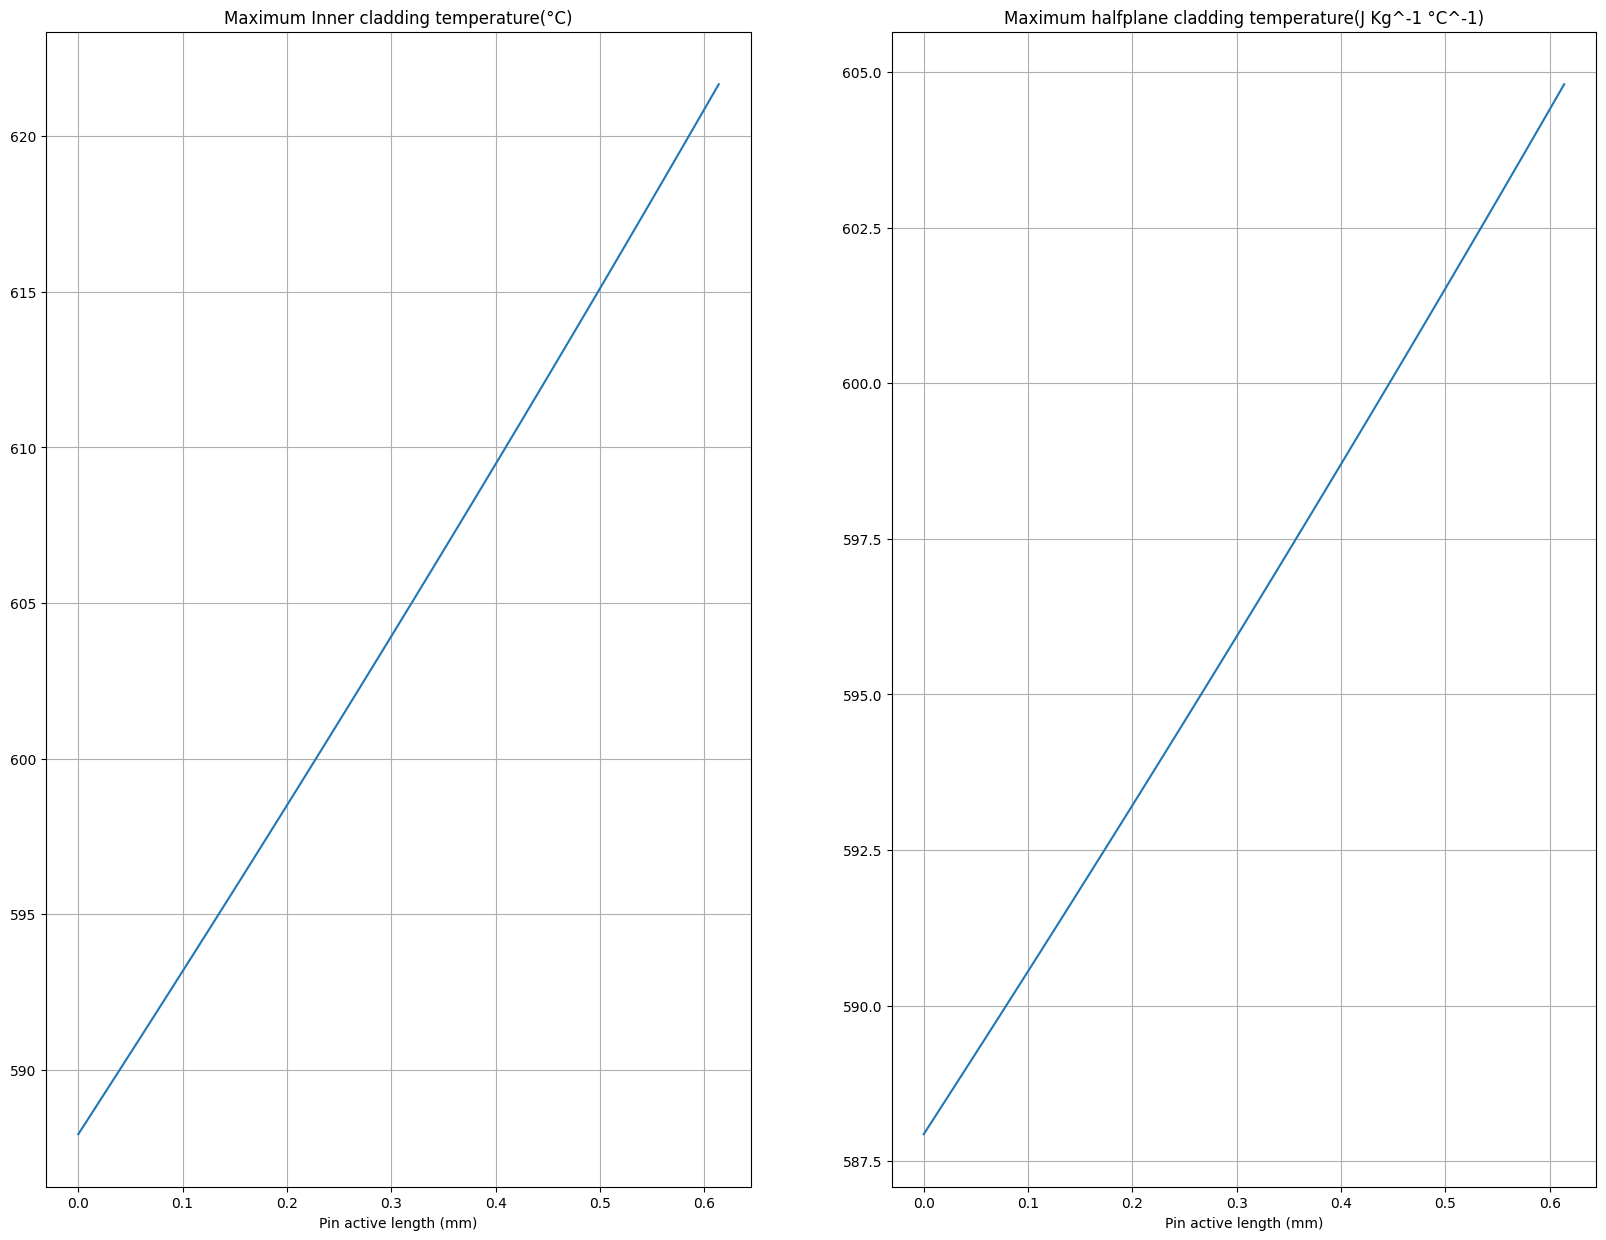

In [115]:
# Inner cladding temperature (equazione risolta con fsolve)
q=np.zeros(len(Pf))
Tci=np.zeros(len(Pf))

TciMAX=np.zeros(count)
halplane_max=np.zeros(count)

#Thermal conductivity of the cladding #W/m/K
def k_cladding(T):
   
   return (13.95 + 0.01163*T) 

#linear power @nodes W/mm
for i in range(len(Pf)): 
    q[i]=Pf[i]*Ppeak


def Tcisolver(Tx, Tco_input, q_input, t_input): #this function implements eq. 3 where Tx is Tcii
        
        return ((Tx - Tco_input)/q_input) - (math.log(Rco/(Rco-t_input)))/(2*math.pi*k_cladding((Tx+Tco_input)/2)/1000)

k=0

while k<count: #for each cladding thickness value, maximum temperature @halfplane and inside cladding are calculated

    ProfileInner=np.zeros(len(Pf))
    ProfileHalfPlane=np.zeros(len(Pf))

    for i in range(len(Pf)):
        sol=fsolve(func=Tcisolver, x0=400, args=(Tco[i], q[i], tc[k])) #solves for Tx
        ProfileInner[i]=sol[0]
        ProfileHalfPlane[i]=0.5*(Tco[i]+ProfileInner[i]) #average at each node of inner and outer cladding temperature

    halplane_max[k]=max(ProfileHalfPlane) #maximum temperature @ midplane
    TciMAX[k]=max(ProfileInner) #maximum temperature inside cladding
    k=k+1

#plots
fig, axs = plt.subplots(1, 2, figsize=(20,15))

axs[0].plot(tc, TciMAX)
axs[0].set_title('Maximum Inner cladding temperature(°C)')
axs[0].set_xlabel("Pin active length (mm)")
axs[0].grid()

axs[1].plot(tc, halplane_max)
axs[1].set_title('Maximum halfplane cladding temperature(J Kg^-1 °C^-1)')
axs[1].set_xlabel("Pin active length (mm)")
axs[1].grid()

Given the results obtained, a cladding thickness is proposed and verified *a posteriori* given that the limit is T<620°C @ cladding midwall

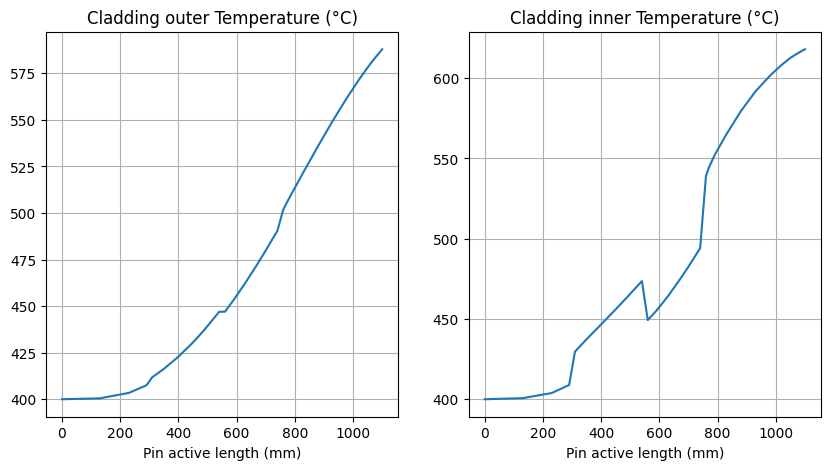

In [116]:
#Cladding inner temperature

TC=0.55                     #proposed cladding thickness (mm)
Rci=Rco-TC                  #external radius of the cladding is the difference between external and thickness

Tci=np.zeros(len(H))

#for each node, the temperature is calculated as per eq. 3

for i in range(len(H)):
      sol=fsolve(func=Tcisolver, x0=400, args=(Tco[i], q[i], TC))
      Tci[i]=sol[0]


#plots
fig, axs = plt.subplots(1, 2, figsize=(10,5))

axs[0].plot(H, Tco)
axs[0].set_title('Cladding outer Temperature (°C)')
axs[0].set_xlabel("Pin active length (mm)")
axs[0].grid()
axs[1].plot(H, Tci)
axs[1].set_title('Cladding inner Temperature (°C)')
axs[1].set_xlabel("Pin active length (mm)")
axs[1].grid()

**Fuel Outer temperature**\
In the evaluation of the temperature variation across the gap, the following assumptions are made:
1. only the term due to the conduction heat transfer is considered (at least for now). This is due to the fact that in cold geometry there is no contribution of contact pressure (there is no swelling/expansion) and the radiative contribution is order of magnitudes lower than the conduction term;
2. The $t_{eff}$ of the gap is calculated as:
\begin{equation}
t_{eff}=R_{c,i}-R_{f,o}+t_{jump}\\
t_{jump}(He)≃10μm
\end{equation}
3.  We assumed $r_{gap}$ to be $r_{c,i}$ because it's the most conservtive estimate;
4.  Since $K=K(T)$, we used $T=\frac{T_{f,o}+T_{c,i}}{2}$ as a reference for K computation.

So:
\begin{equation}
T_{f,o}=T_{c,i}+q'(z)R_{gap}=T_{c,i}+\frac{q'(z)}{h(T)2πr_{gap}}=T_{c,i}+\frac{q'(z)t_{eff}}{K(\frac{T_{f,o}+T_{c,i}}{2})2πr_{gap}}
\end{equation}

Text(0.5, 0, 'Pin active length (mm)')

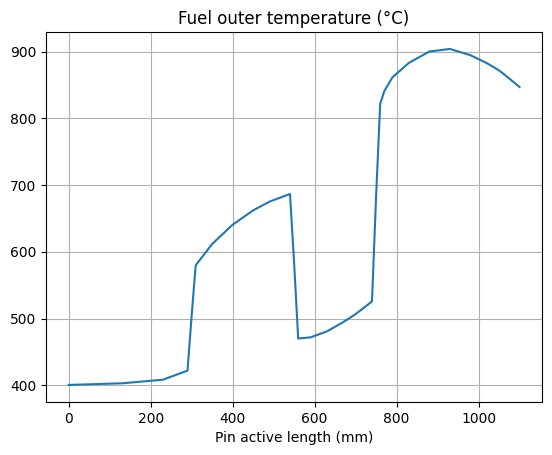

In [117]:
#Fuel outer temperature

i=0

Tfo=np.zeros(len(H))

def K_gap(T_input): #fuel-clkadding gap conductivity

    return 15.8*(10**(-4))*((273.15 + (T_input))**(0.79))

def Tfosolver(Tx, Tci_input, q_input, Rci_input, Rfo_input):

    return ((Tx - Tci_input)/q_input) - (Rci_input-Rfo_input)/(2*math.pi*Rci_input*(K_gap((Tx + Tci_input)/2))*0.001)

for i in range(len(H)):
    sol=fsolve(Tfosolver,1000, args=(Tci[i], q[i], Rci, Rfo))
    Tfo[i]=sol[0]


plt.plot(H,Tfo)
plt.grid()
plt.title('Fuel outer temperature (°C)')
plt.xlabel("Pin active length (mm)")

**Inner Fuel temperature**\
In the evaluation of the temperature variation across the fuel, the following assumptions and reasonings were made:
1.  for the porosity:
\begin{equation}
p=1-\frac{\rho_{real}}{\rho_{theoretical}}
\end{equation}
which is equivalent to stating that the deviation from the TD is due to the voids in the fuel material;
2.  for the burnup, $Bu=0$ because we are in cold geometry, we assume the fuel is fresh;
3.  for the themal resistance, up to 300mm and between 600mm and 800mm we deal with nat-u oxide pellets, otherwise it's MOX.

So:

\begin{equation}
T_{f,i}^{MOX}(z)=T_{f,o}+q'(z)R_{MOX}
\end{equation}

\begin{equation}
T_{f,i}^{UO_2}(z)=T_{f,o}+q'(z)R_{UO_2}
\end{equation}

And since the two kind of pellets have a different geometry:
\begin{equation}
R_{MOX}=\frac{1-log((\frac{r_{f,o}}{r_{f,i}})^2)}{(\frac{r_{f,o}}{r_{f,i}})^2-1}\frac{1}{4πK_{MOX}(\frac{T_{f,i}+T_{f,o}}{2},Bu, O/M)}
\end{equation}

\begin{equation}
R_{UO_2}=\frac{1}{4πK_{UO_2}(\frac{T_{f,i}+T_{f,o}}{2},Bu, O/M)}
\end{equation}

Text(0.5, 0, 'Pin active length (mm)')

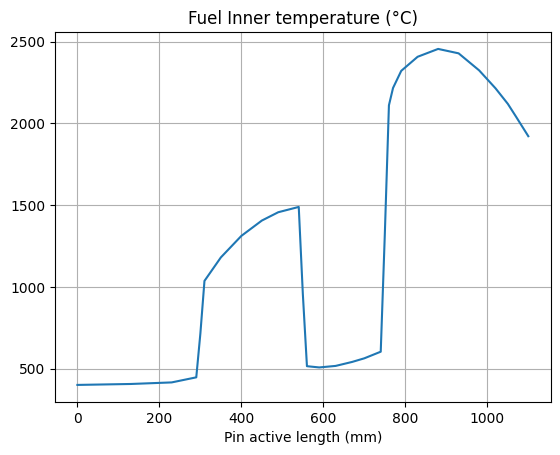

In [118]:
#Fuel inner temperature

Rfi=2.45/2 # mm

dev=0.05
BUFIMA=0 #cold geometry
por=0.05

Tfi=np.zeros(len(H))

def K_UO_2(burnup_input, T_input, p_input):  #fertile pellets, W/m K function of burnup, temperature and porosity of fuel

    return (1/(0.115+(2.6*10**(-3))*burnup_input+2.745*T_input*10**(-4))+1.216*10**(-2)*math.exp(1.867*T_input*10**(-3)))*((1-(2.58-5.8*T_input*10**-4)*p_input)/(1-((2.58-5.8*T_input*10**-4)*0.05)))

def Tfisolver_UO_2(Tx, Tfo_input, q_input, p_input):  #equation for inner T of fertile pellets

    return ((Tx - Tfo_input)/(q_input)) - 1/(4*math.pi*K_UO_2(0, (Tx+Tfo_input)*0.5, p_input)/1000)

def K_MOX(burnup_input, T_input, p_input, x_input): #fissile pellets, W/m K function of burnup, temperature, porosity of fuel and Pu content

    return (1/(1.528*math.sqrt(x_input+0.0093)-0.1055+0.44*burnup_input+2.885*T_input*10**-4)+76.4*(T_input**3)*10**(-12))*1.16*(1-p_input)/(1+2*p_input)

def Tfisolver_MOX(Tx, Tfo_input, q_input, Rfo_input, Rfi_input, p_input, x_input):#equation for inner T of fissile pellets
     
     return ((Tx - Tfo_input)/(q_input)) - (1-(math.log((Rfo_input/Rfi_input)**2))/((Rfo_input/Rfi_input)**2 -1))*(1/(4*math.pi*(0.001*K_MOX(0, 0.5*(Tx+Tfo_input), p_input, x_input ))))


for i in range(len(H)):
    if H[i]<=300 or (H[i]>=550 and H[i]<=750):
        sol=fsolve(Tfisolver_UO_2,1000, args=(Tfo[i], q[i], 1-rhof))
        Tfi[i]=sol[0]
    else:
        sol=fsolve(Tfisolver_MOX,1000, args=(Tfo[i], q[i], Rfo, Rfi, 1-rhof, x_fissile))
        Tfi[i]=sol[0]



plt.plot(H, Tfi)
plt.grid()
plt.title('Fuel Inner temperature (°C)')
plt.xlabel("Pin active length (mm)")

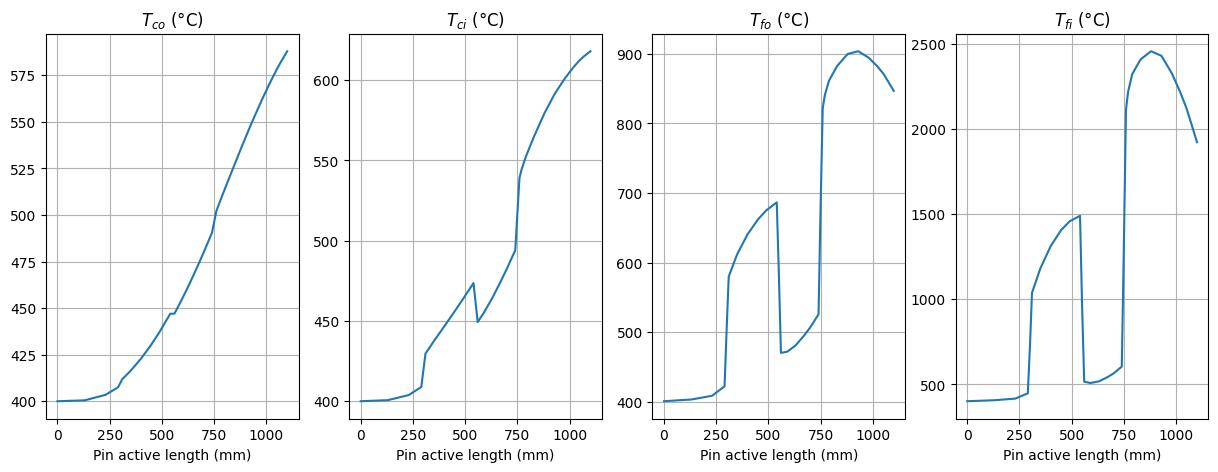

In [119]:
#plots
fig, axs = plt.subplots(1, 4, figsize=(15,5))

axs[0].plot(H, Tco)
axs[0].set_title('$T_{co}$ (°C)')
axs[0].set_xlabel("Pin active length (mm)")
axs[0].grid()
axs[1].plot(H, Tci)
axs[1].set_title('$T_{ci}$ (°C)')
axs[1].set_xlabel("Pin active length (mm)")
axs[1].grid()
axs[2].plot(H, Tfo)
axs[2].set_title('$T_{fo}$ (°C)')
axs[2].set_xlabel("Pin active length (mm)")
axs[2].grid()
axs[3].plot(H, Tfi)
axs[3].set_title('$T_{fi}$ (°C)')
axs[3].set_xlabel("Pin active length (mm)")
axs[3].grid()

Note that the maximum inner fuel temperature exceeds the design limit for the fuel temperature (<2400°C).

Yet, the cold geometry analysis does not take into account the thermal expansion of the materials involve, as seen later on in the hot geometry analysis. As shown, the thermal expansion of both fuel and cladding reduces the thermal resistance of the system and hence the maximum T.

Cold geometry temperature radial profile @ hottest node

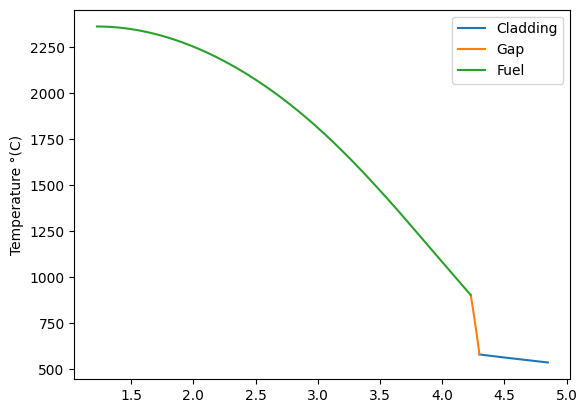

In [120]:
def dTdr_cladding (r,T,  q_input):

    return -q_input*1000/(2*math.pi*k_cladding(T)*r)

def dTdr_gap (r,T, q_input):

    return -q_input*1000/(2*math.pi*K_gap(T)*r)

def dTdr_fuelMOX (r,T,q_input, Bu_input, p_input, x_input):

    return -q_input*1000*(r**2-Rfi**2)/(Rfo**2-Rfi**2)/(2*math.pi*K_MOX(Bu_input, T, p_input, x_input)*r)

r_cladding=np.linspace(Rco,Rci, int((Rco-Rci)*1000))
r_gap=np.linspace(Rci,Rfo, int((Rci-Rfo)*1000))
r_fuel=np.linspace(Rfo,Rfi, int((Rfo-Rfi)*1000))

cladding_cold_profile=integrate.solve_ivp(dTdr_cladding, t_span=(Rco, Rci), t_eval=r_cladding, y0=[Tco[np.where(Tfi==max(Tfi))[0][0]]], args=(q[np.where(Tfi==max(Tfi))[0][0]],))
gap_cold_profile=integrate.solve_ivp(dTdr_gap, t_span=(Rci, Rfo), t_eval=r_gap, y0=[cladding_cold_profile.y[0][-1]], args=(q[np.where(Tfi==max(Tfi))[0][0]],))
fuel_cold_profile=integrate.solve_ivp(dTdr_fuelMOX, t_span=(Rfo, Rfi), t_eval=r_fuel, y0=[gap_cold_profile.y[0][-1]], args=(q[np.where(Tfi==max(Tfi))[0][0]],0, 1-rhof, x_fissile))

plt.plot(cladding_cold_profile.t, cladding_cold_profile.y[0], label="Cladding")
plt.plot(gap_cold_profile.t, gap_cold_profile.y[0], label="Gap")
plt.plot(fuel_cold_profile.t, fuel_cold_profile.y[0], label="Fuel")
plt.ylabel("Temperature °(C)")
plt.legend()


# Hot geometry

The aim of this section is to use the temperatures found in the previous section to compute the thermal expansion of the materials.\
Under these new circumstances, we repeat the previously done calculation.

In [121]:
def epsilon(T_input): # T °C, epsilon \
    
    return -3.101*10**-4+1.545*10**-5*(T_input)+2.75*10**-9*(T_input)**2

The following equation will be applied for both internal and external radii, and for both cladding and fuel:
\begin{equation}
r=r_0[1+ϵ_{th}(T)]=r_0[1+α(T)(T-T_{ref})]
\end{equation}
The temperature for the cladding, the filling gas and the fuel will be the average between internal and external.

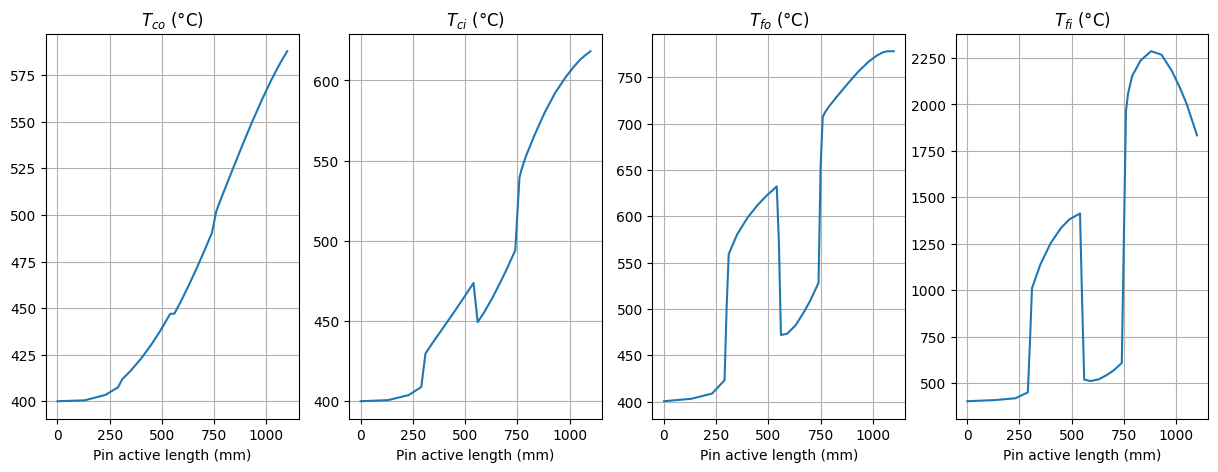

In [122]:
j=0
Rco_hot=np.zeros(len(H))
Rci_hot=np.zeros(len(H))
Rfo_hot=np.zeros(len(H))
Rfi_hot=np.zeros(len(H))

Tco_hot=np.copy(Tco)
Tci_hot=np.copy(Tci)
Tfo_hot=np.copy(Tfo)
Tfi_hot=np.copy(Tfi)

while j<1000:
    
    #new geometry
    for i in range(len(H)):
        Rco_hot[i]=Rco*(1+epsilon((Tco_hot[i]+Tci_hot[i])/2))
        Rci_hot[i]=Rci*(1+epsilon((Tco_hot[i]+Tci_hot[i])/2))
        Rfo_hot[i]=Rfo*(1+alpha*(-25+(Tfo_hot[i]+Tfi_hot[i])/2))
        for i in range(len(H)):
            if H[i]<=300 or (H[i]>=550 and H[i]<=750):
                Rfi_hot[i]=0
            else:
                Rfi_hot[i]=Rfi*(1+alpha*(-25+(Tfo_hot[i]+Tfi_hot[i])/2))
        
        

    
    for i in range(len(H)):
        #Tco
        Tco_hot[i]=T[i]+(q[i]*1000/(h_v[i]*2*math.pi*(Rco_hot[i]/1000)))
        #Tci
        sol=fsolve(func=Tcisolver, x0=400, args=(Tco_hot[i], q[i], Rco_hot[i]-Rci_hot[i]))
        Tci_hot[i]=sol[0]
        #Tfo
        sol=fsolve(Tfosolver,1000, args=(Tci_hot[i], q[i], Rci_hot[i], Rfo_hot[i]))
        Tfo_hot[i]=sol[0]
        #Tfi
        if H[i]<=300 or (H[i]>=550 and H[i]<=750):
            sol=fsolve(Tfisolver_UO_2,1000, args=(Tfo_hot[i], q[i], 1-rhof))
            Tfi_hot[i]=sol[0]
        else:
            sol=fsolve(Tfisolver_MOX,1000, args=(Tfo_hot[i], q[i],Rfo_hot[i], Rfi_hot[i], 1-rhof, x_fissile))
            Tfi_hot[i]=sol[0]
    
    j=j+1

for i in range(len(H)): #check for contact between fuel and cladding due to th. expansion
    if Rfo_hot[i]>=Rci_hot[i]:
                print(j)
                print("Contatto fuel-cladding")


#plots
fig, axs = plt.subplots(1, 4, figsize=(15,5))

axs[0].plot(H, Tco_hot)
axs[0].set_title('$T_{co}$ (°C)')
axs[0].set_xlabel("Pin active length (mm)")
axs[0].grid()
axs[1].plot(H, Tci_hot)
axs[1].set_title('$T_{ci}$ (°C)')
axs[1].set_xlabel("Pin active length (mm)")
axs[1].grid()
axs[2].plot(H, Tfo_hot)
axs[2].set_title('$T_{fo}$ (°C)')
axs[2].set_xlabel("Pin active length (mm)")
axs[2].grid()
axs[3].plot(H, Tfi_hot)
axs[3].set_title('$T_{fi}$ (°C)')
axs[3].set_xlabel("Pin active length (mm)")
axs[3].grid()


This time, the T design limit for fuel (2400°C) is not reached

Hot geometry temperature radial profile @ hottest node

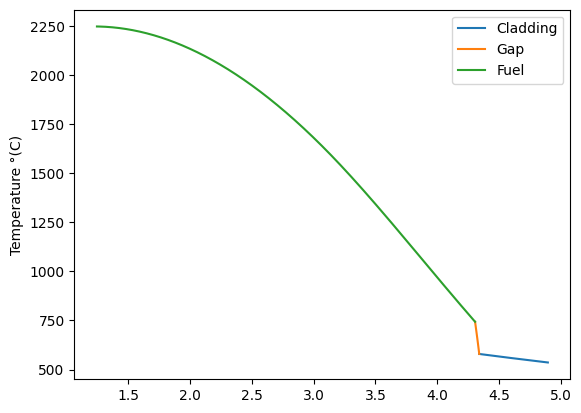

In [123]:
r_cladding_hot=np.linspace(Rco_hot[np.where(Tfi==max(Tfi))][0],     Rci_hot[np.where(Tfi==max(Tfi))][0],      int((Rco_hot[np.where(Tfi==max(Tfi))]-Rci_hot[np.where(Tfi==max(Tfi))])*1000))
r_gap_hot=np.linspace(Rci_hot[np.where(Tfi_hot==max(Tfi_hot))][0],   Rfo_hot[np.where(Tfi_hot==max(Tfi_hot))][0],       int((Rci_hot[np.where(Tfi_hot==max(Tfi_hot))]-Rfo_hot[np.where(Tfi_hot==max(Tfi_hot))])*1000))
r_fuel_hot=np.linspace(Rfo_hot[np.where(Tfi_hot==max(Tfi_hot))][0],     Rfi_hot[np.where(Tfi_hot==max(Tfi_hot))][0],         int((Rfo_hot[np.where(Tfi_hot==max(Tfi_hot))]-Rfi_hot[np.where(Tfi_hot==max(Tfi_hot))])*1000))


cladding_hot_profile=integrate.solve_ivp(dTdr_cladding, t_span=(r_cladding_hot[0], r_cladding_hot[-1]), t_eval=r_cladding_hot, y0=[Tco[np.where(Tfi==max(Tfi))[0][0]]], args=(q[np.where(Tfi==max(Tfi))[0][0]],))
gap_hot_profile=integrate.solve_ivp(dTdr_gap, t_span=(r_gap_hot[0], r_gap_hot[-1]), t_eval=r_gap_hot, y0=[cladding_hot_profile.y[0][-1]], args=(q[np.where(Tfi==max(Tfi))[0][0]],))
fuel_hot_profile=integrate.solve_ivp(dTdr_fuelMOX, t_span=(r_fuel_hot[0], r_fuel_hot[-1]), t_eval=r_fuel_hot, y0=[gap_hot_profile.y[0][-1]], args=(q[np.where(Tfi==max(Tfi))[0][0]],0, 1-rhof, x_fissile))

plt.plot(cladding_hot_profile.t, cladding_hot_profile.y[0], label="Cladding")
plt.plot(gap_hot_profile.t, gap_hot_profile.y[0], label="Gap")
plt.plot(fuel_hot_profile.t, fuel_hot_profile.y[0], label="Fuel")
plt.ylabel("Temperature °(C)")
plt.legend()

# Fuel restructuring

When reaching 1600°C, the oxide fuel undergoes a migration of the porosity voids following the temperature gradient, hence towards the center, increasing the radius of the central pellet hole or creating it where not present. As a consequence, an anular region at the center of the pellet with lower (almost zero) porosity, called columnar region. This region begins where the fuel reaches 1600°C, at a point called columnar radius. This process is part of a range of phenomena called fuel restructuring.



In [124]:
def R_columnar_solver(Rfi_input, Tx, Tfo_input, q_input, Rfo_input): # same equation for inner T of fissile pellets, but looking for Rfi given Tfi=1600
     
     return ((Tx - Tfo_input)/(q_input)) - (1-(math.log((Rfo_input/Rfi_input)**2))/((Rfo_input/Rfi_input)**2 -1))*(1/(4*math.pi*(0.001*K_MOX(0, 0.5*(Tx+Tfo_input), 1-rhof, x_fissile ))))


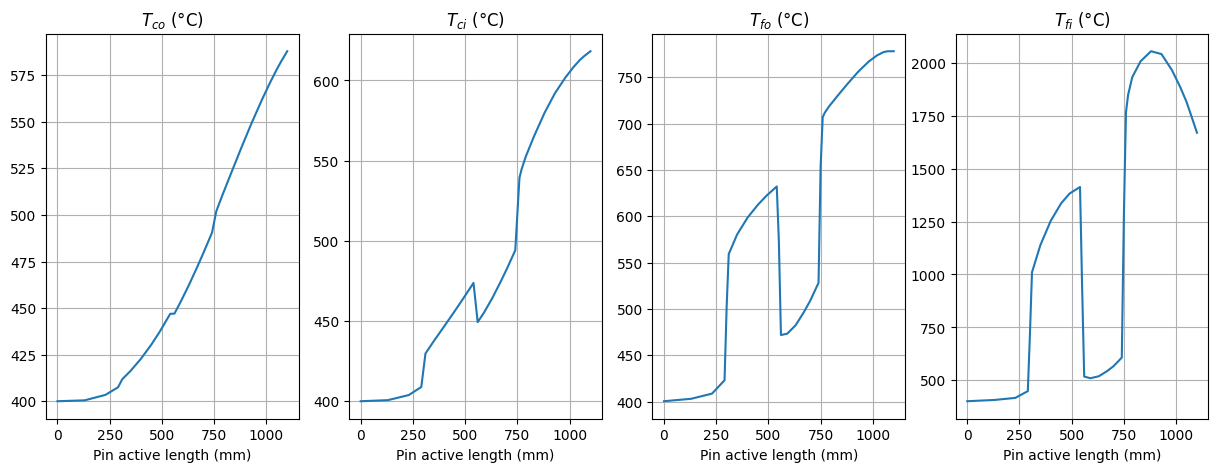

In [125]:
Rfi_res=np.zeros(len(H))
R_columnar=np.zeros(len(H))
Tfi_res=np.zeros(len(H))

for i in range(len(H)):
    if Tfi_hot[i]>=1600: #if the maximun temperature of the fuel reaches 1600°C, restructuring of the fuel takes place

        sol=fsolve(R_columnar_solver,Rfi, args=(1600,Tfo_hot[i], q[i], Rfo_hot[i])) #columnar radius calculatioon

        R_columnar[i]=sol[0]

        Rfi_res[i]=math.sqrt((R_columnar[i]**2)-rhof*(R_columnar[i]**2-Rfi_hot[i]**2))

        #new inner temperature is found after restructuring by modelling the columnar zone as a new inner cylindrical shell with a different porosity and hence a different thermal conductivity
        if H[i]<=300 or (H[i]>=550 and H[i]<=750): 
            sol=fsolve(Tfisolver_UO_2,1000, args=(Tfo_hot[i], q[i], 0))
            Tfi_res[i]=sol[0] 
        else:
            sol=fsolve(Tfisolver_MOX,1000, args=(Tfo_hot[i], q[i],Rfo_hot[i], Rfi_hot[i], 0, x_fissile))
            Tfi_res[i]=sol[0]

    else:
        Rfi_res[i]=Rfi_hot[i]
        Tfi_res[i]=Tfi_hot[i]


#plots
fig, axs = plt.subplots(1, 4, figsize=(15,5))

axs[0].plot(H, Tco_hot)
axs[0].set_title('$T_{co}$ (°C)')
axs[0].set_xlabel("Pin active length (mm)")
axs[0].grid()
axs[1].plot(H, Tci_hot)
axs[1].set_title('$T_{ci}$ (°C)')
axs[1].set_xlabel("Pin active length (mm)")
axs[1].grid()
axs[2].plot(H, Tfo_hot)
axs[2].set_title('$T_{fo}$ (°C)')
axs[2].set_xlabel("Pin active length (mm)")
axs[2].grid()
axs[3].plot(H, Tfi_res)
axs[3].set_title('$T_{fi}$ (°C)')
axs[3].set_xlabel("Pin active length (mm)")
axs[3].grid()

As seen, the maximum temperature of the fuel is further lowered due to this phenomenon.

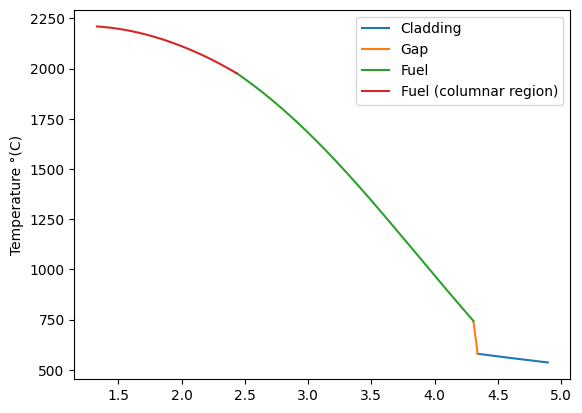

In [126]:
r_cladding_res=np.linspace(Rco_hot[np.where(Tfi==max(Tfi))][0],     Rci_hot[np.where(Tfi==max(Tfi))][0],      int((Rco_hot[np.where(Tfi==max(Tfi))]-Rci_hot[np.where(Tfi==max(Tfi))])*1000))
r_gap_res=np.linspace(Rci_hot[np.where(Tfi_hot==max(Tfi_hot))][0],   Rfo_hot[np.where(Tfi_hot==max(Tfi_hot))][0],       int((Rci_hot[np.where(Tfi_hot==max(Tfi_hot))]-Rfo_hot[np.where(Tfi_hot==max(Tfi_hot))])*1000))
r_fuel_res=np.linspace(Rfo_hot[np.where(Tfi_hot==max(Tfi_hot))][0],     R_columnar[np.where(Tfi_hot==max(Tfi_hot))][0],         int((Rfo_hot[np.where(Tfi_hot==max(Tfi_hot))]-R_columnar[np.where(Tfi_hot==max(Tfi_hot))])*1000))
r_columnar_res=np.linspace(R_columnar[np.where(Tfi_hot==max(Tfi_hot))][0],  Rfi_res[np.where(Tfi_hot==max(Tfi_hot))][0], int((R_columnar[np.where(Tfi_hot==max(Tfi_hot))]-Rfi_res[np.where(Tfi_hot==max(Tfi_hot))])*1000))


cladding_res_profile=integrate.solve_ivp(dTdr_cladding, t_span=(r_cladding_res[0], r_cladding_res[-1]), t_eval=r_cladding_res, y0=[Tco[np.where(Tfi==max(Tfi))[0][0]]], args=(q[np.where(Tfi==max(Tfi))[0][0]],))
gap_res_profile=integrate.solve_ivp(dTdr_gap, t_span=(r_gap_res[0], r_gap_res[-1]), t_eval=r_gap_res, y0=[cladding_res_profile.y[0][-1]], args=(q[np.where(Tfi==max(Tfi))[0][0]],))
fuel_res_profile_external=integrate.solve_ivp(dTdr_fuelMOX, t_span=(r_fuel_res[0], r_fuel_res[-1]), t_eval=r_fuel_res, y0=[gap_res_profile.y[0][-1]], args=(q[np.where(Tfi==max(Tfi))[0][0]],0, 1-rhof, x_fissile))
fuel_res_profile_columnar=integrate.solve_ivp(dTdr_fuelMOX, t_span=(r_columnar_res[0], r_columnar_res[-1]), t_eval=r_columnar_res, y0=[fuel_res_profile_external.y[0][-1]],args=(q[np.where(Tfi==max(Tfi))[0][0]],0, 0, x_fissile))

plt.plot(cladding_res_profile.t, cladding_res_profile.y[0], label="Cladding")
plt.plot(gap_res_profile.t, gap_res_profile.y[0], label="Gap")
plt.plot(fuel_res_profile_external.t, fuel_res_profile_external.y[0], label="Fuel")
plt.plot(fuel_res_profile_columnar.t, fuel_res_profile_columnar.y[0], label="Fuel (columnar region)")
plt.ylabel("Temperature °(C)")
plt.legend()


# Fuel longitudinal expansion

The fuel expands longitudinally due to thermal swelling.

In [127]:
H_expanded=np.zeros(len(H))

H_expanded[0]=H[0] #new position of nodes

for i in range(len(H)-1): #each position is calculated as the undeformed 
    H_expanded[i+1]=H_expanded[i]+(H[i+1]-H[i])*(1+alpha*(-25+(Tfi_res[i+1]+Tfo_hot[i+1]+Tfi_res[i]+Tfo_hot[i])/2))



# Burnup, power and neutron flux analysis

The burnup of the fuel is calculated at every node such that the average value at the end of operation coincides with the target fuel burnup expressed in GWd/t. Then, it is converted to FIMA (Fissions per Initial Fissile Atom).

In [128]:
#Maximum Burnup along z calculation

def BurnupFinder(Burnup_max_value):
    x=0
    for i in range(len(H)):
        x=x+Pf[i]

    return x/len(H)*Burnup_max_value - TargetB

Burnup_max=fsolve(BurnupFinder, 100) #GWd/t



In [129]:
#Some useful function fo the conversion of burnup
#from GWd/t to fissions/heavy metal atom (FIMA)

def Joule_to_eV (Energy):

    return (Energy/1.602)*10**19

def GWd_t_to_J_g (Energy):

    return Energy*1000*24*60*60 

def eV_to_fissions (Energy):

    return Energy/200/10**6


In [130]:
burnup_final=np.zeros(len(H)) #burnup values at nodes (GWd/t)
burnup_final_FIMA=np.zeros(len(H))  #burnup values at nodes (FIMA)

for i in range(len(burnup_final)):
    burnup_final[i]=Burnup_max[0]*Pf[i] #GWd/t 

    temp= GWd_t_to_J_g(burnup_final[i]) #J/g
    temp=Joule_to_eV(temp) #eV/g
    temp=eV_to_fissions(temp) #fissions/g

    if H[i]<=300 or (H[i]>=550 and H[i]<=750): 
        
        burnup_final_FIMA[i]=temp*MM_UO_2/Nav
    else:
        burnup_final_FIMA[i]=temp*MM_MOX/Nav



Due to the burnup of the fuel, the power is expected to lower by 10% in four years, approximately linearly. As a consequence, the neutron flux will decrease and with it the yearly burnup contribution. In the following, the burnup is calculated at the end of each year, while the power and the neutron flux correspond to the value during the year.

In [131]:
def burnup_splitter(b_up_yearly, target): #this function is used to find the value of the contribution of each year
                                            #target is the final value of burnup
    return b_up_yearly*(1+0.975+0.95+0.925)-target

burnup_yearly=np.zeros([4,len(H)]) #Burnup array 4 years x 30 nodes
power_yearly=np.zeros([4,len(H)])  #Linear power array "
tot_neutron_flux_local=np.zeros([4,len(H)]) #total neutron flux array "

for i in range(len(burnup_yearly)):
    for j in range(len(burnup_yearly[i])):
        if i==0:
            burnup_yearly[i][j]=(fsolve(burnup_splitter, 0.1, args=(burnup_final_FIMA[j]))[0])
            tot_neutron_flux_local[i][j]=fluxt*Pf[j]
        else:
            burnup_yearly[i][j]=burnup_yearly[i-1][j]+burnup_yearly[0][j]*(1-0.025*j)
            tot_neutron_flux_local[i][j]=tot_neutron_flux_local[0][j]*(1-0.025*i)
        power_yearly[i][j]=q[j]*(1-0.025*i)
        

# Cladding void swelling

The previously calculated neutron flux can be used to estimate the void swelling of the cladding due to irradiation.

In [132]:
void_swelling=np.zeros([4,len(H)])
void_swelling_total=np.zeros(len(H))
Rco_new=np.zeros(len(H))
Rci_new=np.zeros(len(H))

def clad_void_swelling(T, phi,t): #dV/V (%)
    
    return 1.5*10**-3*math.exp(-2.5*((T-450)/100)**2)*(phi*t/10**22)**2.75


for i in range(len(void_swelling)):
    for j in range(len(void_swelling[i])):
        void_swelling[i][j]=clad_void_swelling((Tco_hot[i]+Tci_hot[i])/2, tot_neutron_flux_local[i][j], 360*24*60*60)



for j in range(len(H)):
    for i in range(len(void_swelling)):
        void_swelling_total[j]+=void_swelling[i][j]

for i in range(len(H)):
    Rco_new[i]=Rco_hot[i]*(1+(void_swelling_total[i]/3/100))
    Rci_new[i]=Rci_hot[i]*(1+(void_swelling_total[i]/3/100))

# Fuel swelling

In [133]:
Rfi_new=np.zeros(len(H))
Rfo_new=np.zeros(len(H))
H_swelled=np.zeros(len(H))

H_swelled[0]=H[0] #new position of nodes

def swelling_strain(burnup): #(%), burnup in GWd/t

    return 0.07*burnup

for i in range(len(H)):

    Rfi_new[i]=Rfi_res[i]*(1+swelling_strain(burnup_final[i])*0.01/3)
    Rfo_new[i]=Rfo_hot[i]*(1+swelling_strain(burnup_final[i])*0.01/3)
    if i<len(H)-1:
        H_swelled[i+1]=H_swelled[i]+(H_expanded[i+1]-H_expanded[i])*(1+swelling_strain(burnup_final[i])*0.01/3)


In [134]:
#days=np.linspace(0,1440, 1441)
#Rfo_val2=np.zeros(len(H))
#Rfonew_copia=np.copy(Rfonew)
#Rci_val2=np.zeros(len(H))
#Rcinew_copia=np.copy(Rcinew)
#T_contact=np.zeros(len(H))

#for i in range(len(H)):
#    for t in range(len(days)):
 #       Rfo_val2[i]=Rfonew_copia[i]*(1+(0.07*(Burnup[i]*days[t]/1440)/100)/3)
  #      Rci_val2[i]=Rcinew_copia[i]*(1+(0.01*Radiation_swelling(0.5*(Tcinew[i]+Tconew[i]), fluxf, days[t]*24*3600)/3))
   #     if Rci_val2[i]-Rfo_val2[i]<=0:
#
 #           T_contact[i]=days[t]
  #          break

#display(T_contact)

# Fission Gas Release

Text(0, 0.5, 'Upper Plenum Height (mm)')

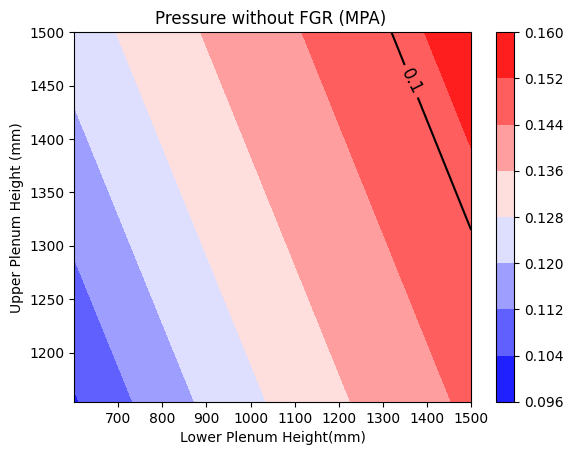

In [135]:
#These two arrays host the possible values for the length of the upper and lower plena of the fuel pin
#The lower boundary of the upper plenum length is set in order to be sufficently long to host the swelled
H_upper_plenum=np.linspace(int(H_swelled[-1])+1, 1500, 1500-int(H_swelled[-1]))
H_lower_plenum=np.linspace(601, 1500, 900)

#These two arrays will conatin the possible values of the volume of the empty space in the fuel pin at beginning and end of the  operative life
#given the lengths of the plena
Vin=np.zeros((len(H_upper_plenum),len(H_lower_plenum)))
Vfin=np.zeros((len(H_upper_plenum),len(H_lower_plenum)))

#These arrays contain the value of the pressure at the end pf the operative life of the pin 
Pgas=np.zeros((len(H_upper_plenum),len(H_lower_plenum))) #without taking into account fission gas release
PgasFGR=np.zeros((len(H_upper_plenum),len(H_lower_plenum))) #and taking into account fission gas release

###################################################################
def V_upper(height, swelled): #this function takes in input the height of the upper plenum and the swelling state of the cladding
                                
    #the function returns the volume of the upper plenum 
    if swelled==False: 

        return math.pi*height*Rci**2
    
    else:
        Vol=0
        for i in range(len(H)-1):
            Vol=Vol+(H[i+1]-H[i])*math.pi*Rci_new[i+1]**2

        Vol=Vol+math.pi*(height-H_swelled[-1])*Rci_new[-1]**2

        return Vol
    
#####################################################################
def V_lower(height, swelled):#this function takes in input the height of the upper plenum and the swelling state of the cladding
    #the function returns the volume of the lower plenum 
    if swelled==False:
        return height*math.pi*Rci**2
    else:
        return height*math.pi*Rci_new[0]**2
    
#####################################################################
def V_initial(H_upper, H_lower): #this function returns the volume of the empty space inside the pin at the beginning of its operative life
                                 #given the length of the plena
    return V_upper(H_upper, swelled=False)+V_lower(H_lower, swelled=False)-math.pi*(Rfo**2-Rfi**2)*(1-por)*600-math.pi*(Rfo**2)*500*(1-por)

#####################################################################
def V_final(H_upper, H_lower):   #this function returns the volume of the empty space inside the pin at the end of its operative life
                                 #given the length of the plena
    Vfuel=0
    for i in range(len(H)-1):
        Vfuel=Vfuel+(H_swelled[i+1]-H_swelled[i])*math.pi*((Rfo_new[i]**-Rfi_new[i]**2)-por*(Rfo_new[i]**2-R_columnar[i]**2))

    return V_upper(H_upper, swelled=True)+V_lower(H_lower, swelled=True) -Vfuel*((1+swelling_strain(TargetB)/100))

#####################################################################
#the total volume of the free space is calculated at beginning and end of the operative life of the pin
#for each possible combination of plena lengths

for i in range(len(H_upper_plenum)):
    for j in range(len(H_lower_plenum)):
        Vin[i][j]=V_initial(H_upper_plenum[i],H_lower_plenum[j])


for i in range(len(H_upper_plenum)):
    for j in range(len(H_lower_plenum)):
        Vfin[i][j]=V_final(H_upper_plenum[i],H_lower_plenum[j])

# Plenum should be designed such that the final gas pressure is greater than the one of the coolant but below the 5MPa deisgn limit.
# The value of the pressure without accounting for FGR is calculated and displayed
for i in range(len(H_upper_plenum)):
    for j in range(len(H_lower_plenum)):
        nHe=(Pingas*(10**6) * Vin[i][j]*10**(-9))/(8.3145*(Tgas+273))
        Pgas[i][j]=(nHe*8.3145*(400+273))/(Vfin[i][j]*10**(-9))*10**-6 # MPa

levels=[0.15, 0.30,0.45,0.6]
plt.figure()
contour = plt.contour( H_lower_plenum,H_upper_plenum, Pgas, levels, colors = 'black')
contour_filled = plt.contourf(H_lower_plenum, H_upper_plenum,  Pgas, cmap='bwr');
plt.clabel(contour, colors = 'black', fmt = '%2.1f', fontsize=12);
plt.colorbar(contour_filled);
plt.title('Pressure without FGR (MPA) ');
plt.xlabel("Lower Plenum Height(mm)")
plt.ylabel("Upper Plenum Height (mm)")

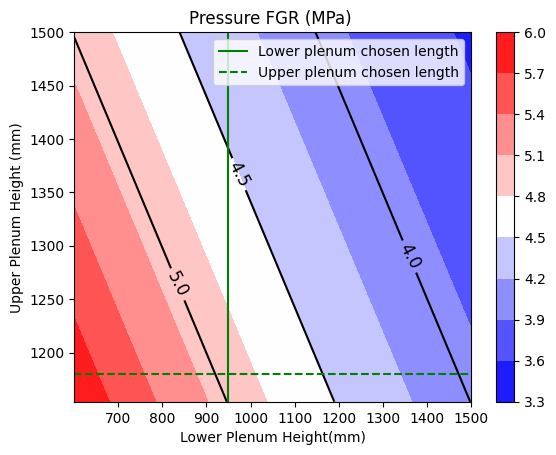

In [136]:
# Some data of interest only for the calculation of the effects of FGR

FGR=0.9 #amount of fission gas atoms rleased from fuel

YrateXe=0.27 # Xe atom released per fission event
YrateKr=0.03 # Kr atom released per fission event
EperFission=200 # Energy released per fission event (MeV)

DenUO2=11 # U oxide density (g/cm3)
DenPuO2= 11.5 # Pu oxide density (g/cm3)


Vfuelfiss=math.pi*(Rfo**2-fiRfi**2)*600 # volume of initial fissile material
Vfuelfert=math.pi*(Rfo**2)*500 # volume of initial fertile material

FuelMass=(Vfuelfiss*(10**(-3))*(DenUO2*0.77 + DenPuO2*0.23) + Vfuelfert*(10**(-3))*(DenUO2))*10**-3 # fuel mass (kg)

Etot=TargetB*(10**9 * 24*60*60)*(FuelMass*10**(-3)) # total energy generated in the whole life of the fuel pin (J)

aFissionEvents=Etot/(EperFission*(10**6) * 1.6*10**(-19)) # all fission events inside a fuel pin

nXe=YrateXe*aFissionEvents/Nav # atoms of Xe produced (mol)
nKr=YrateKr*aFissionEvents/Nav # atoms of Kr produced (mol)

n=nHe+FGR*(nXe+nKr) # fission gas atoms that are realesed in the plenum (mol)


# For each possible plena lengths combination, the final inner pressure of the cladding is calculated and displayed accounting for FGR
for i in range(len(H_upper_plenum)):
    for j in range(len(H_lower_plenum)):
        PgasFGR[i][j]=Pgas[i][j] +FGR*(nKr*8.3145*(400+273))/(Vfin[i][j]*10**(-3)) + FGR*(nXe*8.3145*(400+273))/(Vfin[i][j]*10**(-3))# MPa



levels = [4.0,4.5,5.0,6.0]
plt.figure()
contour = plt.contour( H_lower_plenum,H_upper_plenum, PgasFGR, levels, colors = 'black')
contour_filled = plt.contourf(H_lower_plenum, H_upper_plenum,  PgasFGR, cmap='bwr');
plt.clabel(contour, colors = 'black', fmt = '%2.1f', fontsize=12);
plt.colorbar(contour_filled);
plt.title('Pressure FGR (MPa) ');
plt.xlabel("Lower Plenum Height(mm)")
plt.ylabel("Upper Plenum Height (mm)")
plt.axvline(x=H_lower_plenum[950-600-1], color='g', linestyle='-', label='Lower plenum chosen length')
plt.axhline(y=H_upper_plenum[1180-int(H_swelled[-1]+1)], color='g', linestyle='--', label='Upper plenum chosen length')
plt.legend()


# Thermal analysis of fuel-cladding contact

In [137]:
#Tfuelin
BUFIMA=0
Tfo_contact=np.copy(Tfonew)
Tfi_contact=np.copy(Tfinew)
for i in range(len(H)):
    Potenza=0.9*Ppeak*Pf[i]*1000
    if Rci_final[i]-Rfo_val[i]<=0:
        Tfo_contact[i]=Tcinew[i]
        if (H[i]<=300 or (H[i]>=600 and H[i]<=800)) and Rfi_res[i]==0:
            def Tfisolver(Tx):
                return ((Tx - Tfo_contact[i])/Potenza) - 1/(4*math.pi* (1.216*10**(-2)*math.exp(1.867*10**(-3)*((Tx+Tfo_contact[i])/2)) + 1/(0.115 + 2.6*10**(-3)*BUFIMA + 2.475*((Tx+Tfo_contact[i])/2)*10**(-4)) ) * ( (1 - por*(2.58-((Tx+Tfo_contact[i])/2)*5.8*10**(-4)) ) / ( 1 - 0.05*(2.58-((Tx+Tfo_contact[i])/2)*5.8*10**(-4)) ) ) )
            sol=fsolve(Tfisolver,1000)
            Tfi_contact[i]=sol[0]
        elif H[i]<=300 or (H[i]>=600 and H[i]<=800):
            def Tfisolver(Tx):
                return ((Tx - Tfo_contact[i])/Potenza) - (1-(math.log((Rci_final[i]/Rfi_val[i])**2))/((Rci_final[i]/Rfi_val[i])**2 -1))/(4*math.pi* (1.216*10**(-2)*math.exp(1.867*10**(-3)*((Tx+Tfo_contact[i])/2)) + 1/(0.115 + 2.6*10**(-3)*BUFIMA + 2.475*((Tx+Tfo_contact[i])/2)*10**(-4)) ) * ( (1 - por*(2.58-((Tx+Tfo_contact[i])/2)*5.8*10**(-4)) ) / ( 1 - 0.05*(2.58-((Tx+Tfo_contact[i])/2)*5.8*10**(-4)) ) ) )
            sol=fsolve(Tfisolver,1000)
            Tfi_contact[i]=sol[0]
        else:
            def Tfisolver(Tx):
                return ((Tx - Tfo_contact[i])/Potenza) - (1-(math.log((Rci_final[i]/Rfi_val[i])**2))/((Rci_final[i]/Rfi_val[i])**2 -1))*(1/(4*math.pi*(( 76.4*10**(-12)*((Tx+Tfo_contact[i]+273*2)/2)**3 + 1/(1.528*math.sqrt(dev+0.0093) - 0.1055 + 0.44*BUFIMA + ((Tx+Tfo_contact[i]+273*2)/2)*2.885*10**(-4)) )) * 1.16 * ((1-por)/(1+2*por))))
            sol=fsolve(Tfisolver,1000)
            Tfi_contact[i]=sol[0]
    else:
        def Tfosolver(Tx):
            return ((Tx - Tcinew[i])/Potenza) - (Rci_final[i]-Rfo_val[i]+0.01)/(2*math.pi*Rci_final[i]*(15.8*(10**(-4))*((273.15 + ((Tx + Tcinew[i])/2))**(0.79))))
        sol=fsolve(Tfosolver,1000)
        Tfo_contact[i]=sol[0]

        if (H[i]<=300 or (H[i]>=600 and H[i]<=800)) and Rfi_res[i]==0:
            def Tfisolver(Tx):
                return ((Tx - Tfo_contact[i])/Potenza) - 1/(4*math.pi* (1.216*10**(-2)*math.exp(1.867*10**(-3)*((Tx+Tfo_contact[i])/2)) + 1/(0.115 + 2.6*10**(-3)*BUFIMA + 2.475*((Tx+Tfo_contact[i])/2)*10**(-4)) ) * ( (1 - por*(2.58-((Tx+Tfo_contact[i])/2)*5.8*10**(-4)) ) / ( 1 - 0.05*(2.58-((Tx+Tfo_contact[i])/2)*5.8*10**(-4)) ) ) )
            sol=fsolve(Tfisolver,1000)
            Tfi_contact[i]=sol[0]
        elif H[i]<=300 or (H[i]>=600 and H[i]<=800):
            def Tfisolver(Tx):
                return ((Tx - Tfo_contact[i])/Potenza) - (1-(math.log((Rfo_val[i]/Rfi_val[i])**2))/((Rfo_val[i]/Rfi_val[i])**2 -1))/(4*math.pi* (1.216*10**(-2)*math.exp(1.867*10**(-3)*((Tx+Tfo_contact[i])/2)) + 1/(0.115 + 2.6*10**(-3)*BUFIMA + 2.475*((Tx+Tfo_contact[i])/2)*10**(-4)) ) * ( (1 - por*(2.58-((Tx+Tfo_contact[i])/2)*5.8*10**(-4)) ) / ( 1 - 0.05*(2.58-((Tx+Tfo_contact[i])/2)*5.8*10**(-4)) ) ) )
            sol=fsolve(Tfisolver,1000)
            Tfi_contact[i]=sol[0]
        else:
            def Tfisolver(Tx):
                return ((Tx - Tfo_contact[i])/Potenza) - (1-(math.log((Rfo_val[i]/Rfi_val[i])**2))/((Rfo_val[i]/Rfi_val[i])**2 -1))*(1/(4*math.pi*(( 76.4*10**(-12)*((Tx+Tfo_contact[i]+273*2)/2)**3 + 1/(1.528*math.sqrt(dev+0.0093) - 0.1055 + 0.44*BUFIMA + ((Tx+Tfo_contact[i]+273*2)/2)*2.885*10**(-4)) )) * 1.16 * ((1-por)/(1+2*por))))
            sol=fsolve(Tfisolver,1000)
            Tfi_contact[i]=sol[0]

plt.plot(H,Tfi_contact)
plt.grid()


NameError: name 'Tfonew' is not defined

In [ ]:
for i in range(len(H)):
    if Rcinew[i]-Rfo_val[i]<=0:
        Rfo_val2[i]=Rfo*(1+alpha*((Tfo_contact[i]+Tfi_contact[i])/2-273.15))*(1+0.07*Burnup[i]/100)**(2/3)

display(Rci_final-Rfo_val2)

array([ 0.09348919,  0.09217925,  0.09060149,  0.0840934 ,  0.02614592,
       -0.12038495, -0.16203929, -0.19767309, -0.22135935, -0.23314665,
       -0.23893887, -0.08092779,  0.0778661 ,  0.08146995,  0.08221515,
        0.07916208,  0.07605164,  0.06969984, -0.16130791, -0.38302993,
       -0.41208868, -0.44116531, -0.47069065, -0.4818993 , -0.47001551,
       -0.43498008, -0.39990705, -0.37062303, -0.34716897, -0.311908  ])

# Fuel Margin to melting

In [ ]:
def Tm_fuel(Bu, P,x):
    return 2964.92+((3147-364.85*P-1014.15*x)-2964.92)*math.exp(-Bu/40.43)



Pu_in=0.30/3 #[Pu]
Pu_out=0.23/3


Tm_f=np.zeros((2, len(H)))
for i in range(len(H)):
    Tm_f[0][i]=Tm_fuel(0,Pu_in,0.03)
    Tm_f[1][i]=Tm_fuel(0,Pu_out,0)

margin=min([min(Tm_f[0][:]-Tfinew),min(Tm_f[1][:]-Tfonew)])

print(margin)

Tm_f_end=np.zeros((2, len(H)))
for i in range(len(H)):
    Tm_f_end[0][i]=Tm_fuel(TargetB,Pu_in,0.03)
    Tm_f_end[1][i]=Tm_fuel(TargetB,Pu_out,0)

margin_end=min([min(Tm_f[0][:]-Tfi_contact),min(Tm_f[1][:]-Tfo_contact)])
print(margin_end)

791.9092735181107
1125.4955878407818


# Thermal creep condition

In [ ]:
Tcreep=np.zeros(len(H))
Tm_cladding=1400
for i in range(len(H)):
    Tcreep[i]=(Tcinew[i]+273.15)/(Tm_cladding+273.15)
display(Tcreep)


array([0.40235787, 0.40275456, 0.40465461, 0.40765059, 0.41385669,
       0.42005446, 0.42466903, 0.43019864, 0.43580548, 0.44041446,
       0.44630632, 0.43907459, 0.43181191, 0.43533572, 0.44078305,
       0.44687646, 0.45171087, 0.45857034, 0.47205934, 0.4853982 ,
       0.48851451, 0.49322709, 0.50086931, 0.50952869, 0.51686615,
       0.52272708, 0.5267377 , 0.52934327, 0.53073521, 0.53256868])

# funzioni utili

In [ ]:
R=1.986 #cal/mol K
E_av=2 #Mev
v_f=0.32
def v_cladding(T):
    return 	0.277+6*10**-5*T

def Young_c(T):#GPa, T in celsius
    return 202.7-81.67*10**-3*T

def Young_f(T,Por):#MPa, T in celsius
    return (22.43*10**4-31.19*T)*(1-2.6*Por)

def Rupture_strain_c(T): #%
    return 8+4.74*10**-3*(T-500)+6.2*10**-5*(T-500)*2

def Yield_stress_c(T):#MPa, Ti in °C
    if T<600:
        return 555.5-0.25*T
    elif T<1000:
        return 405.5-0.775*(T-600)
    else:
        return 345.5-0.25*T

def UTS_c(T):
    if T<600:
        return 700-0.3125*T
    elif T<1000:
        return 512.5-0.969*(T-600)
    else:
        return 437.5-0.3125*T

def Irr_creep_strain_rate_c(sigma_eq):
        return 3.2*10**-24*E_av*fluxf*sigma_eq
def Tcreep_strain_rate_c(T,sigma_eq): #T in °C
    return 2.3*10**14*math.e**(-84600/(R*(T+273.15)))*math.sinh(34.54*sigma_eq/(0.8075*R*(T+273.15)))


# Radial Temperature Profile

Cold Geometry

Text(0, 0.5, 'Temperature (°C)')

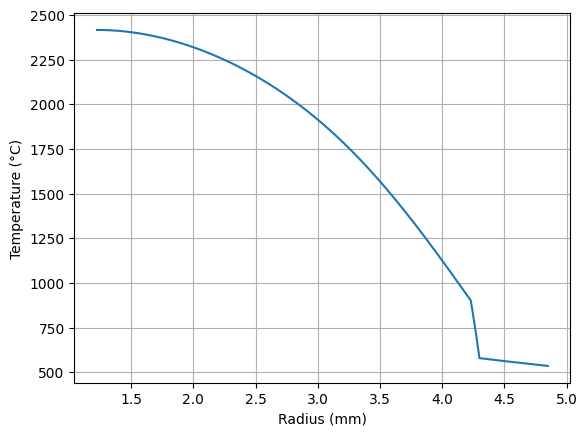

In [ ]:
rvals1=np.linspace(Rco, Rci, int((Rco-Rci)*100))
rvals2=np.linspace(Rci, Rfo, int((Rci-Rfo)*100))
rvals3=np.linspace(Rfo,Rfi,int((Rfo-Rfi)*100))
dev=0.05
BUFIMA=0 #cold geometry
por=0.05


def dT_claddingdr(r, T_cladding):
    def K_cladding(T_cladding):
        return 13.95+0.01163*T_cladding
    return -Ppeak*Pf[23]/(2*math.pi*r*K_cladding(T_cladding)/1000)

sol1=integrate.solve_ivp(dT_claddingdr, (rvals1[0],rvals1[-1]), [Tco[23]], t_eval=rvals1)
T_c=sol1.y[0]

def dT_gapdr(r, T_gap):
    def K_gap(T_gap):
        return 15.8*10**-4*(T_gap+273.15)**0.79
    return -Ppeak*Pf[23]/(2*math.pi*r*K_gap(T_gap)/1000)

sol2=integrate.solve_ivp(dT_gapdr, (rvals2[0],rvals2[-1]), [T_c[-1]], t_eval=rvals2)
T_g=sol2.y[0]

def dT_fueldr(r, T_fuel):
    def K_fuel(T_fuel):
        return ((76.4*10**(-12)*(T_fuel+273)**3 + 1/(1.528*math.sqrt(dev+0.0093)-0.1055+0.44*BUFIMA+(T_fuel+273)*2.885*10**(-4))))*1.16*((1-por)/(1+2*por))
    return -Ppeak*Pf[23]*(r**2-Rfi**2)/((Rfo**2-Rfi**2)*2*math.pi*r*K_fuel(T_fuel)/1000)

sol3=integrate.solve_ivp(dT_fueldr, (rvals3[0],rvals3[-1]), [T_g[-1]], t_eval=rvals3)
T_f=sol3.y[0]

rvals=np.concatenate((rvals1,rvals2,rvals3))
T_profile=np.concatenate((T_c,T_g,T_f))
plt.plot(rvals, T_profile)
plt.grid()
plt.xlabel("Radius (mm)")
plt.ylabel("Temperature (°C)")

In [ ]:
print(max(T_profile))

2415.7378381286035


In [ ]:
print(Rcinew[23])
print(Rfonew[23])

4.339392738402301
4.305644261182437


Hot geometry after restructuring

Text(0, 0.5, 'Temperature (°C)')

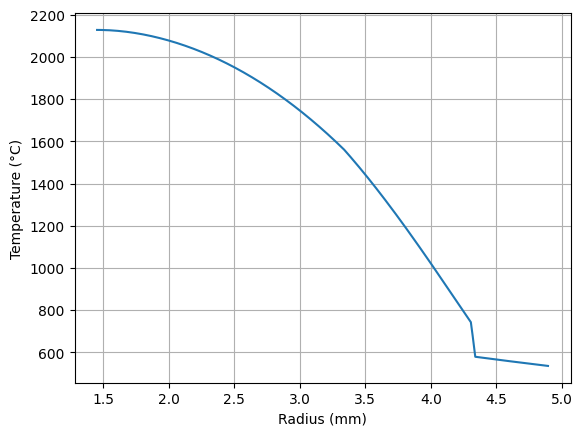

In [ ]:
rvals1=np.linspace(Rconew[23], Rcinew[23], 60)
rvals2=np.linspace(Rcinew[23], Rfonew[23], 60)
rvals3=np.linspace(Rfonew[23],Rcol[23], 60)
rvals4=np.linspace(Rcol[23],Rfinew[23], 60)
dev=0.05
BUFIMA=0 #cold geometry
por=0.05

def dT_claddingdr(r, T_cladding):
    def K_cladding(T_cladding):
        return 13.95+0.01163*T_cladding
    return -Ppeak*Pf[23]/(2*math.pi*r*K_cladding(T_cladding)/1000)

sol1=integrate.solve_ivp(dT_claddingdr, (rvals1[0],rvals1[-1]), [Tconew[23]], t_eval=rvals1)
T_c=sol1.y[0]

def dT_gapdr(r, T_gap):
    def K_gap(T_gap):
        return 15.8*10**-4*(T_gap+273.15)**0.79
    return -Ppeak*Pf[23]/(2*math.pi*r*K_gap(T_gap)/1000)

sol2=integrate.solve_ivp(dT_gapdr, (rvals2[0],rvals2[-1]), [T_c[-1]], t_eval=rvals2)
T_g=sol2.y[0]

def dT_fueldr(r, T_fuel):
    def K_fuel(T_fuel):
        return ((76.4*10**(-12)*(T_fuel+273)**3 + 1/(1.528*math.sqrt(dev+0.0093)-0.1055+0.44*BUFIMA+(T_fuel+273)*2.885*10**(-4))))*1.16*((1-por)/(1+2*por))
    return -Ppeak*Pf[23]*(r**2-Rfinew[23]**2)/((Rfonew[23]**2-Rfinew[23]**2)*2*math.pi*r*K_fuel(T_fuel)/1000)

sol3=integrate.solve_ivp(dT_fueldr, (rvals3[0],rvals3[-1]), [T_g[-1]], t_eval=rvals3)
T_f1=sol3.y[0]

dev=0.05
BUFIMA=0 #cold geometry
por=0
sol4=integrate.solve_ivp(dT_fueldr, (rvals4[0],rvals4[-1]), [T_f1[-1]], t_eval=rvals4)
T_f2=sol4.y[0]

rvals=np.concatenate((rvals1,rvals2,rvals3,rvals4))
T_profile=np.concatenate((T_c,T_g,T_f1,T_f2))

plt.plot(rvals, T_profile)
plt.grid()
plt.xlabel("Radius (mm)")
plt.ylabel("Temperature (°C)")


Cladding mechanical verification

C:\Users\User\AppData\Local\Temp\ipykernel_4124\1662859579.py:17: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  sigma_cladding_rt[i]=M*(((rvals[i]**2-rvals[0]**2)/(rvals[-1]**2-rvals[0]**2))*np.trapz(T_x_r,rvals)-np.trapz(T_x_r[0:i+1], rvals[0:i+1]))
C:\Users\User\AppData\Local\Temp\ipykernel_4124\1662859579.py:18: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  sigma_cladding_thetat[i]=M*(((rvals[i]**2+rvals[0]**2)/(rvals[-1]**2-rvals[0]**2))*np.trapz(T_x_r,rvals)+np.trapz(T_x_r[0:i+1], rvals[0:i+1])-T_x_r2[i])


array([-5.00000000e+00, -4.89899766e+00, -4.79864867e+00, -4.69894742e+00,
       -4.59988832e+00, -4.50146589e+00, -4.40367468e+00, -4.30650930e+00,
       -4.20996443e+00, -4.11403478e+00, -4.01871515e+00, -3.92400038e+00,
       -3.82988535e+00, -3.73636502e+00, -3.64343438e+00, -3.55108849e+00,
       -3.45932245e+00, -3.36813142e+00, -3.27751060e+00, -3.18745524e+00,
       -3.09796067e+00, -3.00902222e+00, -2.92063530e+00, -2.83279536e+00,
       -2.74549789e+00, -2.65873845e+00, -2.57251260e+00, -2.48681600e+00,
       -2.40164431e+00, -2.31699325e+00, -2.23285860e+00, -2.14923617e+00,
       -2.06612179e+00, -1.98351137e+00, -1.90140083e+00, -1.81978616e+00,
       -1.73866337e+00, -1.65802851e+00, -1.57787768e+00, -1.49820701e+00,
       -1.41901268e+00, -1.34029089e+00, -1.26203789e+00, -1.18424997e+00,
       -1.10692346e+00, -1.03005470e+00, -9.53640088e-01, -8.77676061e-01,
       -8.02159080e-01, -7.27085644e-01, -6.52452286e-01, -5.78255574e-01,
       -5.04492107e-01, -

array([41.74118231, 41.64017998, 41.53983099, 41.44012973, 41.34107064,
       41.24264821, 41.144857  , 41.04769162, 40.95114674, 40.8552171 ,
       40.75989747, 40.66518269, 40.57106767, 40.47754733, 40.38461669,
       40.2922708 , 40.20050476, 40.10931373, 40.01869291, 39.92863756,
       39.83914298, 39.75020453, 39.66181761, 39.57397767, 39.48668021,
       39.39992076, 39.31369492, 39.22799831, 39.14282662, 39.05817557,
       38.97404092, 38.89041848, 38.8073041 , 38.72469368, 38.64258315,
       38.56096848, 38.47984568, 38.39921082, 38.31905999, 38.23938933,
       38.16019499, 38.0814732 , 38.00322021, 37.92543229, 37.84810577,
       37.77123701, 37.6948224 , 37.61885838, 37.5433414 , 37.46826796,
       37.3936346 , 37.31943789, 37.24567442, 37.17234083, 37.09943379,
       37.02694999, 36.95488617, 36.88323908, 36.81200552, 36.74118231])

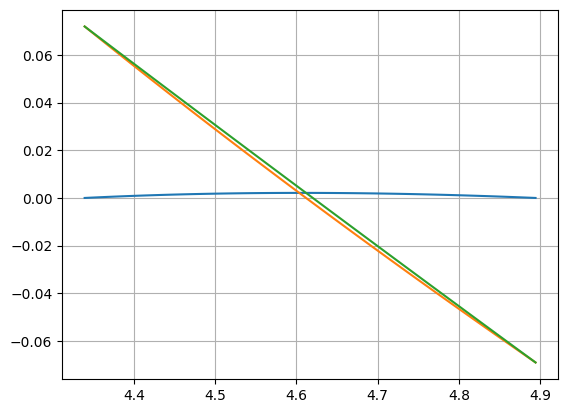

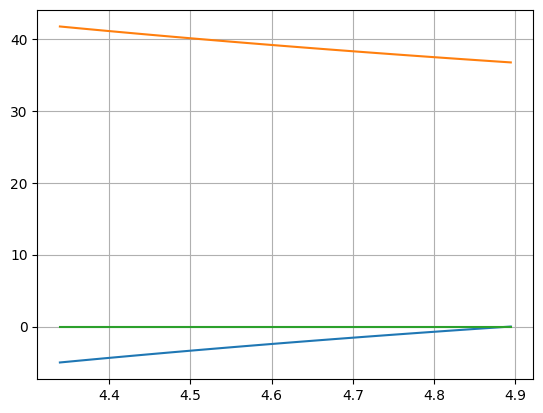

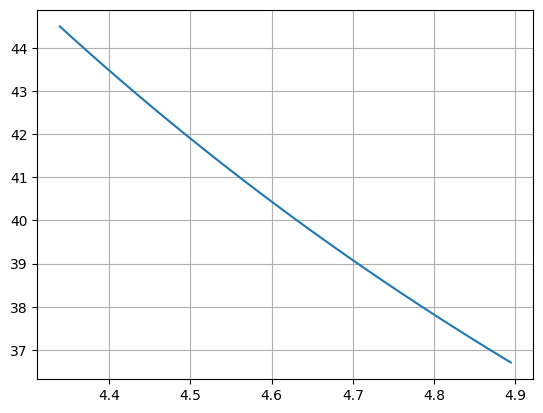

In [ ]:
#Thermal

rvals=np.flip(np.copy(sol1.t))
Tvals=np.flip(np.copy(sol1.y[0]))

alpha_c=(-3.101*10**-4+1.545*10**-5*(Tvals)+2.75*10**-9*(Tvals)**2)/(Tvals-25)/100
sigma_cladding_rt=np.zeros(len(rvals))
sigma_cladding_thetat=np.zeros(len(rvals))
sigma_cladding_zt=np.zeros(len(rvals))

T_x_r=np.multiply(np.copy(Tvals),np.copy(rvals))
T_x_r2=np.multiply(np.copy(T_x_r),np.copy(rvals))

for i in range(len(rvals)):
    M=alpha_c[i]*Young_c(Tvals[i])*10**3/(1-v_c(Tvals[i]))/rvals[i]**2

    sigma_cladding_rt[i]=M*(((rvals[i]**2-rvals[0]**2)/(rvals[-1]**2-rvals[0]**2))*np.trapz(T_x_r,rvals)-np.trapz(T_x_r[0:i+1], rvals[0:i+1]))
    sigma_cladding_thetat[i]=M*(((rvals[i]**2+rvals[0]**2)/(rvals[-1]**2-rvals[0]**2))*np.trapz(T_x_r,rvals)+np.trapz(T_x_r[0:i+1], rvals[0:i+1])-T_x_r2[i])
    sigma_cladding_zt[i]=sigma_cladding_rt[i]+sigma_cladding_thetat[i]

plt.figure()
plt.plot(rvals, sigma_cladding_rt)
plt.plot(rvals, sigma_cladding_thetat)
plt.plot(rvals, sigma_cladding_zt)
plt.grid()

#Mechanical
a,b,r=sp.symbols("a b r")
sigma_r=a/r**2+b

sigma_cladding_rm=np.zeros(len(rvals))
sigma_cladding_thetam=np.zeros(len(rvals))
sigma_cladding_zm=np.zeros(len(rvals))
C1=sp.Eq(sigma_r.subs(r,rvals[0]),-5) #MPa
C2=sp.Eq(sigma_r.subs(r,rvals[-1]),0) #MPa

parameters=sp.solve((C1,C2), [a,b])
sigma_r=sigma_r.subs(parameters)
sigma_theta=sigma_r+r*sigma_r.diff(r,1)

for i in range(len(rvals)):
    sigma_cladding_rm[i]=sigma_r.subs(r, rvals[i])
    sigma_cladding_thetam[i]=sigma_theta.subs(r, rvals[i])
display(sigma_cladding_rm,sigma_cladding_thetam)

plt.figure()
plt.plot(rvals, sigma_cladding_rm)
plt.plot(rvals, sigma_cladding_thetam)
plt.plot(rvals, sigma_cladding_zm)
plt.grid()

#equivalent stress
equivalent_stress=np.zeros(len(rvals))

sigma_cladding_r=sigma_cladding_rm+sigma_cladding_rt
sigma_cladding_theta=sigma_cladding_thetam+sigma_cladding_thetat
sigma_cladding_z=sigma_cladding_zm+sigma_cladding_zt
for i in range(len(rvals)):
    equivalent_stress[i]=math.sqrt(((sigma_cladding_r[i]-sigma_cladding_theta[i])**2+(sigma_cladding_r[i]-sigma_cladding_z[i])**2+(sigma_cladding_theta[i]-sigma_cladding_z[i])**2)/2)
plt.figure()
plt.plot(rvals, equivalent_stress)
plt.grid()

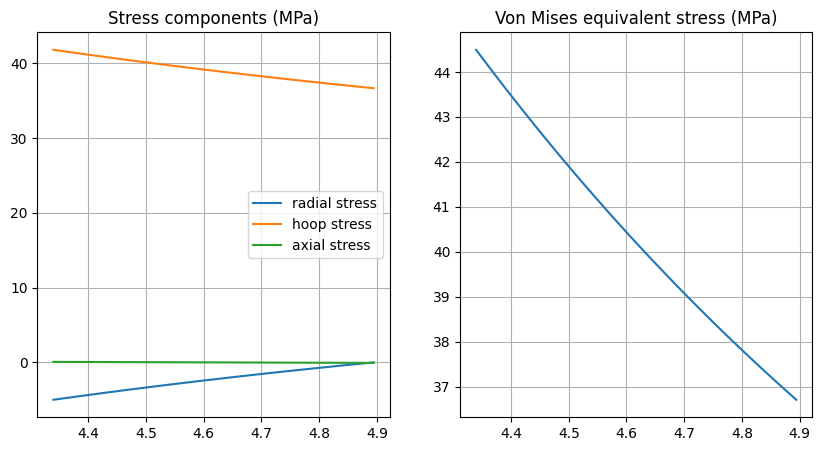

In [ ]:
#plots
fig, axs = plt.subplots(1, 2, figsize=(10,5))

axs[0].plot(rvals, sigma_cladding_r, label="radial stress")
axs[0].plot(rvals, sigma_cladding_theta, label="hoop stress")
axs[0].plot(rvals, sigma_cladding_z, label="axial stress")
axs[0].set_title('Stress components (MPa)')
axs[0].legend()
axs[0].grid()
axs[1].plot(rvals, equivalent_stress)
axs[1].set_title('Von Mises equivalent stress (MPa)')
axs[1].grid()

In [ ]:
print(Yield_stress_c(np.average(T_c)))

416.1678012341385


In [ ]:
print((T_contact[23]))

169.0


Radial Profile with caldding fuel contact

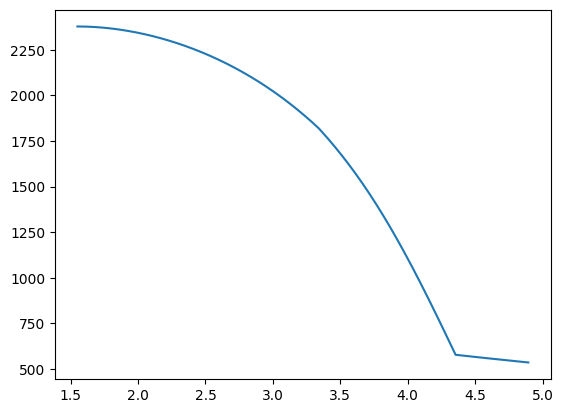

In [ ]:
#work in progress
rvals1=np.linspace(Rconew[23], Rci_final[23], int((Rconew[23]-Rci_final[23])*100))
rvals2=np.linspace(Rci_final[23], Rcol[23], int((Rci_final[23]-Rcol[23])*100))
rvals3=np.linspace(Rcol[23],Rfi_val[23], int((Rcol[23]-Rfi_val[23])*100))
dev=0.05
BUFIMA=1
por=0.05

def dT_claddingdr(r, T_cladding):
    def K_cladding(T_cladding):
        return 13.95+0.01163*T_cladding
    return -Ppeak*Pf[23]/(2*math.pi*r*K_cladding(T_cladding)/1000)

sol1=integrate.solve_ivp(dT_claddingdr, (rvals1[0],rvals1[-1]), [Tconew[23]], t_eval=rvals1)
T_c=sol1.y[0]



def dT_fueldr(r, T_fuel):
    def K_fuel(T_fuel):
        return ((76.4*10**(-12)*(T_fuel+273)**3 + 1/(1.528*math.sqrt(dev+0.0093)-0.1055+0.44*BUFIMA+(T_fuel+273)*2.885*10**(-4))))*1.16*((1-por)/(1+2*por))
    return -Ppeak*Pf[23]*(r**2-Rfi_val[23]**2)/((Rcinew[23]**2-Rfi_val[23]**2)*2*math.pi*r*K_fuel(T_fuel)/1000)



sol2=integrate.solve_ivp(dT_fueldr, (rvals2[0],rvals2[-1]), [T_c[-1]], t_eval=rvals2)

T_f1=sol2.y[0]

dev=0.05
por=0
sol3=integrate.solve_ivp(dT_fueldr, (rvals3[0],rvals3[-1]), [T_f1[-1]], t_eval=rvals3)
T_f2=sol3.y[0]

rvals=np.concatenate((rvals1,rvals2,rvals3))
T_profile=np.concatenate((T_c,T_f1,T_f2))
plt.plot(rvals, T_profile)

# PCI

Raggio interno al giorno di contatto per ogni pellet

In [ ]:
Rfi_first_contact=np.zeros(len(H))
for i in range(len(H)):
    if T_contact[i]!=0:
        Rfi_first_contact[i]=Rfinew[i]*(1+(0.07*(Burnup[i]*T_contact[i]/1440)/100)/3)
display(Rfi_first_contact)

Rci_first_contact=np.zeros(len(H))
for i in range(len(H)):
    if T_contact[i]!=0:
        Rci_first_contact[i]=Rcinew[i]*(1+(0.011*T_contact[i]/1440)/3)
display(Rci_first_contact)

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       1.27538548, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.48774268,
       0.53132441, 0.56881479, 1.4578602 , 1.46375528, 1.46343639,
       1.45621633, 1.44709281, 1.43795095, 1.42941001, 1.41437042])

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       4.33776044, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 4.33916676,
       4.33919604, 4.3394728 , 4.34018433, 4.34126008, 4.34238633,
       4.34356166, 4.34453118, 4.34527066, 4.34580567, 4.34662333])

Contact pressure

0.00011696190247876714
-1.0410625298187507e-05


np.float64(520.7968303680831)

410.9806420009669


array([-5.20796830e+02, -5.08927565e+02, -4.97142588e+02, -4.85441103e+02,
       -4.73822323e+02, -4.62285470e+02, -4.50829777e+02, -4.39454484e+02,
       -4.28158840e+02, -4.16942103e+02, -4.05803541e+02, -3.94742427e+02,
       -3.83758047e+02, -3.72849691e+02, -3.62016660e+02, -3.51258262e+02,
       -3.40573813e+02, -3.29962636e+02, -3.19424064e+02, -3.08957436e+02,
       -2.98562097e+02, -2.88237403e+02, -2.77982714e+02, -2.67797399e+02,
       -2.57680833e+02, -2.47632400e+02, -2.37651489e+02, -2.27737496e+02,
       -2.17889824e+02, -2.08107884e+02, -1.98391091e+02, -1.88738868e+02,
       -1.79150644e+02, -1.69625855e+02, -1.60163943e+02, -1.50764355e+02,
       -1.41426545e+02, -1.32149973e+02, -1.22934105e+02, -1.13778411e+02,
       -1.04682370e+02, -9.56454648e+01, -8.66671829e+01, -7.77470189e+01,
       -6.88844721e+01, -6.00790475e+01, -5.13302551e+01, -4.26376105e+01,
       -3.40006341e+01, -2.54188517e+01, -1.68917939e+01, -8.41899648e+00,
       -2.27373675e-12])

array([4481.53287661, 4469.66361111, 4457.87863389, 4446.17714874,
       4434.55836885, 4423.02151665, 4411.56582366, 4400.19053044,
       4388.89488636, 4377.67814957, 4366.53958681, 4355.47847334,
       4344.49409278, 4333.58573702, 4322.7527061 , 4311.9943081 ,
       4301.30985903, 4290.6986827 , 4280.16011066, 4269.69348203,
       4259.29814347, 4248.97344901, 4238.71875999, 4228.53344496,
       4218.41687955, 4208.36844644, 4198.38753517, 4188.47354215,
       4178.62587048, 4168.84392994, 4159.12713682, 4149.47491391,
       4139.88669036, 4130.36190161, 4120.89998933, 4111.50040131,
       4102.16259138, 4092.88601936, 4083.67015093, 4074.51445762,
       4065.41841668, 4056.38151102, 4047.40322915, 4038.4830651 ,
       4029.62051834, 4020.81509371, 4012.06630139, 4003.37365675,
       3994.73668038, 3986.15489794, 3977.62784016, 3969.15504272,
       3960.73604624])

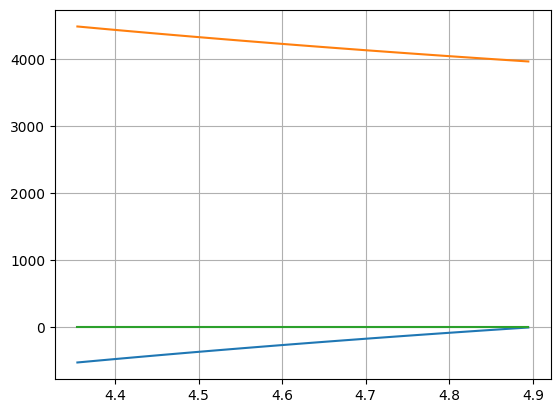

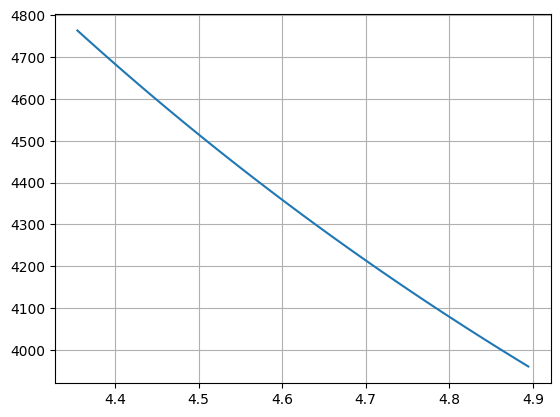

In [ ]:
a=Rfi_val[23]
b=Rfo_val[23]
c=Rco_final[23]

i=(1/3)*Rfonew[23]*(0.07*(Burnup[23]*(1440-T_contact[23])/1440)/100)
print(((1000*Young_c(T_c[-1]))**-1*((b**2+c**2)/(c**2-b**2)+1/v_cladding(T_c[-1]))))
print((Young_f(T_c[-1], Por=0.05)**-1*((a**2+b**2)/(b**2-a**2)-1/v_f)))
p_contact=(i/b)/(((1000*Young_c(T_c[-1]))**-1*((b**2+c**2)/(c**2-b**2)+1/v_cladding(T_c[-1])))+(Young_f(T_c[-1], Por=0.05)**-1*((a**2+b**2)/(b**2-a**2)-1/v_f)))

display(p_contact)
print(Yield_stress_c(T_c[-1]))

rvals=np.flip(sol1.t)
a,b,r=sp.symbols("a b r")
sigma_r=a/r**2+b

sigma_cladding_rm=np.zeros(len(rvals))
sigma_cladding_thetam=np.zeros(len(rvals))
sigma_cladding_zm=np.zeros(len(rvals))
C1=sp.Eq(sigma_r.subs(r,rvals[0]),-p_contact) #MPa
C2=sp.Eq(sigma_r.subs(r,rvals[-1]),0) #MPa

parameters=sp.solve((C1,C2), [a,b])
sigma_r=sigma_r.subs(parameters)
sigma_theta=sigma_r+r*sigma_r.diff(r,1)

for i in range(len(rvals)):
    sigma_cladding_rm[i]=sigma_r.subs(r, rvals[i])
    sigma_cladding_thetam[i]=sigma_theta.subs(r, rvals[i])
display(sigma_cladding_rm,sigma_cladding_thetam)

plt.figure()
plt.plot(rvals, sigma_cladding_rm)
plt.plot(rvals, sigma_cladding_thetam)
plt.plot(rvals, sigma_cladding_zm)
plt.grid()

#equivalent stress
equivalent_stress=np.zeros(len(rvals))

sigma_cladding_r=sigma_cladding_rm
sigma_cladding_theta=sigma_cladding_thetam
sigma_cladding_z=sigma_cladding_zm
for i in range(len(rvals)):
    equivalent_stress[i]=math.sqrt(((sigma_cladding_r[i]-sigma_cladding_theta[i])**2+(sigma_cladding_r[i]-sigma_cladding_z[i])**2+(sigma_cladding_theta[i]-sigma_cladding_z[i])**2)/2)
plt.figure()
plt.plot(rvals, equivalent_stress)
plt.grid()



Strain day

In [ ]:
days=np.linspace(T_contact[23],1440, int(1440-T_contact[23])+1)

for t in range(len(days)):
    print(Rcinew[23])
    Rci_strain=Rcinew[23]*(1+(0.01*Radiation_swelling(np.average(T_c), fluxf, days[t]*24*3600)/3))
    if Rci_strain>=(1+0.002):
        T_strain=days[t]
        break

display(Rci_strain)
print(Yield_stress_c(T_c[-1]))
print(UTS_c(T_c[-1]))

4.339392738402301


np.float64(4.339430832743865)

410.9806420009669
519.3508025012086


Given $T_{des}$ and $\sigma_{des}$ verify $t_r$

In [ ]:
SigmaEq=Yield_stress_c(T_c[-1])
strain=0.2
limit=Rupture_strain_c(np.average(T_c))

def final_strain(t):
    return float(strain+(Irr_creep_strain_rate_c(SigmaEq)+Tcreep_strain_rate_c(np.average(T_c),SigmaEq)+Radiation_swelling(np.average(T_c),fluxf, T_strain*24*3600)/((1440-T_strain)*24))*(t-T_strain)*24)-limit

t_r=fsolve(final_strain, 1440)[0]
print(t_r)

1476.3508987752311


C:\Users\User\AppData\Local\Temp\ipykernel_4124\19672414.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return float(strain+(Irr_creep_strain_rate_c(SigmaEq)+Tcreep_strain_rate_c(np.average(T_c),SigmaEq)+Radiation_swelling(np.average(T_c),fluxf, T_strain*24*3600)/((1440-T_strain)*24))*(t-T_strain)*24)-limit


Given $t_{des}$ and $\sigma_{des}$ verify $T_r$

In [ ]:
def LMP_T(sigma, t):
    T=sp.symbols("T")
    LMP=(2060-sigma)/0.095
    T_rupture=sp.solve(sp.Eq(LMP, (T+273.15)*(17.125+math.log(t*24,10))))
    return T_rupture

print(LMP_T(SigmaEq, 1440-T_strain))
print(np.average(T_c))




[530.117708156209]
556.7035187774791


Given $T_{des}$ and $t_{des}$ verify $\sigma_r$

In [ ]:
def LMP_sigma(T, t):
    sigma=sp.symbols("sigma")
    LMP=(T+273.15)*(17.125+math.log(t*24,10))
    sigma_rupture=sp.solve(sp.Eq(LMP, (2060-sigma)/0.095 ))
    return sigma_rupture

print(LMP_sigma(np.average(T_c), 1440-T_strain))

[356.402926604939]


In [ ]:
T_des=np.average(T_c)+273.15
T_r=LMP_T(SigmaEq, 1440-T_strain)[0]+273.15

Sigma_des=SigmaEq
Sigma_r=LMP_sigma(np.average(T_c), 1440-T_strain)[0]

t_des=1440-T_strain
#t_r c'è già

Verification={"Temperature": T_r/T_des, "Stress": Sigma_r/Sigma_des, "Time-to-Rupture": t_r/t_des}
display(Verification)


{'Temperature': 0.967963248911163,
 'Stress': 0.867201250330668,
 'Time-to-Rupture': np.float64(1.1615664034423534)}